# Noise Analysis
In thi notebook we test the effect of noisy inputs to the model.

In [1]:

%reload_ext autoreload
%autoreload 2

from torchvision import datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import *
import ast
import os
import sys
from statistics import mean
import torch


# import modules from JTAG model
# module_path = os.path.abspath(os.path.join('../../workspace/models/jets/code/')) # or the path to your source code
# sys.path.insert(0, module_path)
# import model as jet_tagger
# import jet_datamodule

# import modules from RN08 model
module_path = os.path.abspath(os.path.join('../../workspace/models/rn08/code/')) # or the path to your source code
sys.path.insert(0, module_path)
import rn08

# import modules from ECON model
module_path = os.path.abspath(os.path.join('../../workspace/models/econ/code/')) # or the path to your source code
sys.path.insert(0, module_path)
import q_autoencoder as econ



## Utility methods

In [2]:
def plot_2d_heatmap(values, 
                    title, 
                    min_max=(0, 1), 
                    x_label='Layers', 
                    y_label='Layers', 
                    scale_label='Value', 
                    cmap='Greens',
                    show_value=True):
    '''
    Method used to plot a 2D heatmap using Seaborn.
    '''
    # Set up the figure and axes
    plt.figure(figsize=(7, 6))

    # Create a heatmap using Seaborn
    sns.heatmap(values, 
                cmap=cmap, 
                annot=show_value, 
                fmt=".2f", 
                vmin=min_max[0], 
                vmax=min_max[1],
                cbar_kws={'label': scale_label})

    # Customize the plot
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    # Display the plot
    plt.show()

In [3]:
# search space
batch_sizes = [16, 32, 64, 128, 256, 512, 1024]
learning_rates = [0.1, 0.05, 0.025, 0.0125, 0.00625, 0.003125, 0.0015625]
precisions = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

# ECON model (Autoencoder)
we focus our analysis on the encoder which will be deploy on an ASIC.

In [4]:
DATA_PATH = '/data/tbaldi/work/checkpoint/'
DATASET_DIR = '../../data/ECON/Elegun'
DATASET_FILE = 'nELinks5.npy'

size = 'baseline'

## EMD results

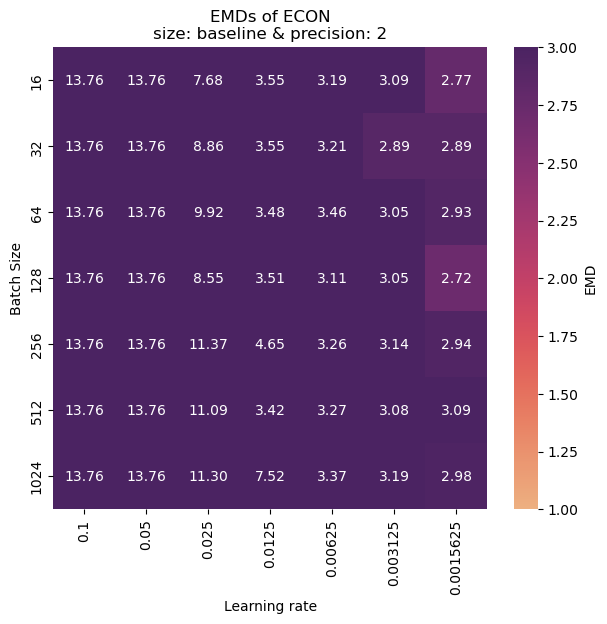

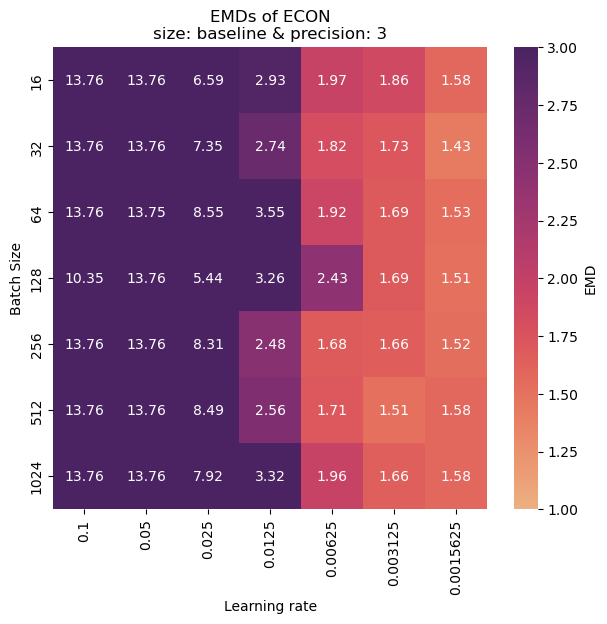

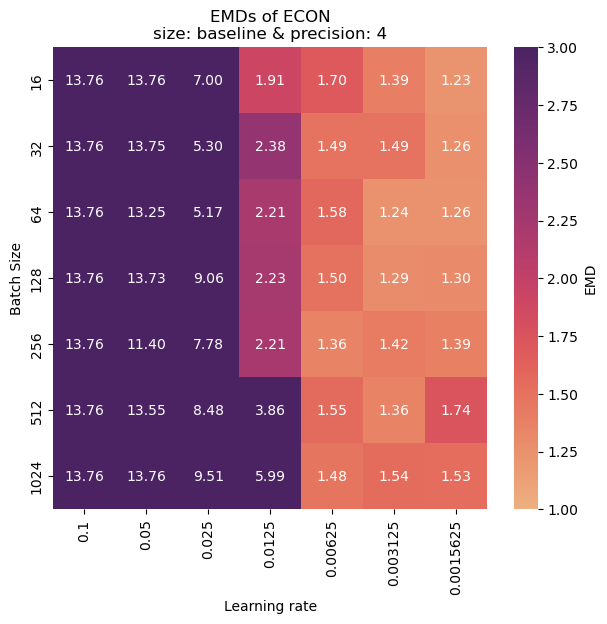

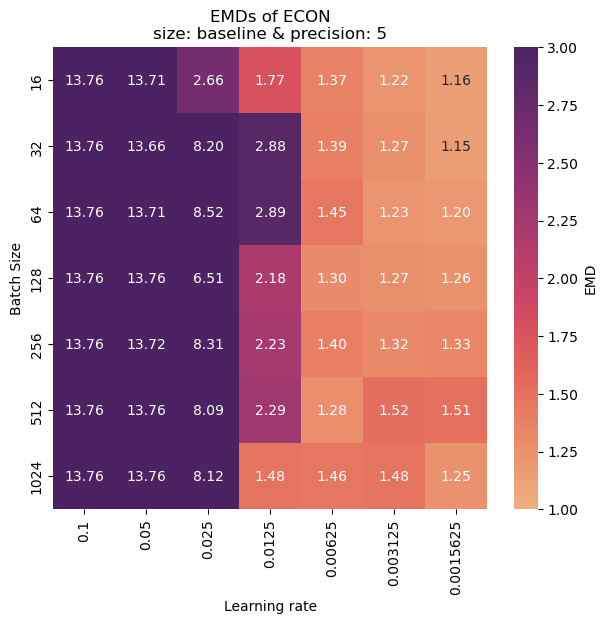

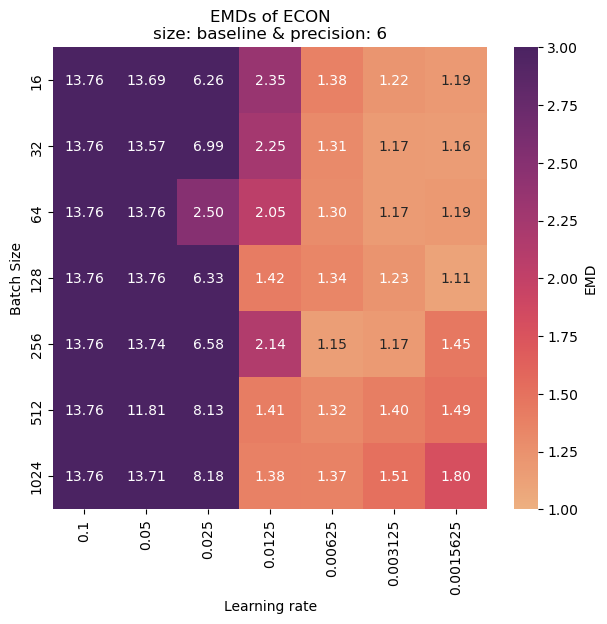

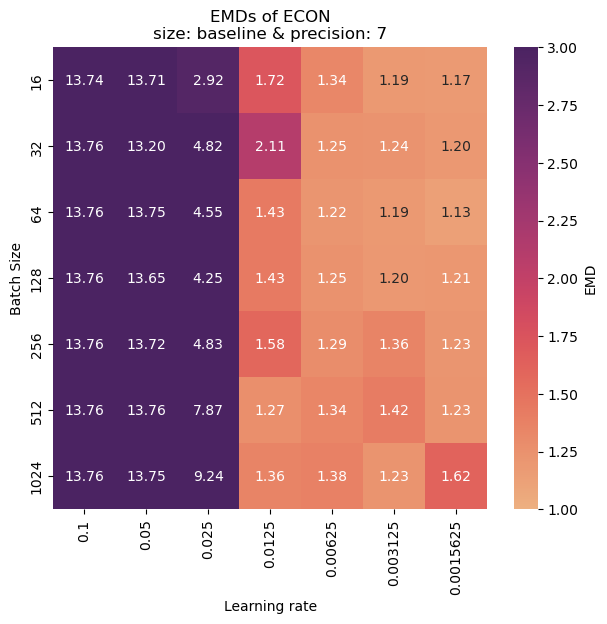

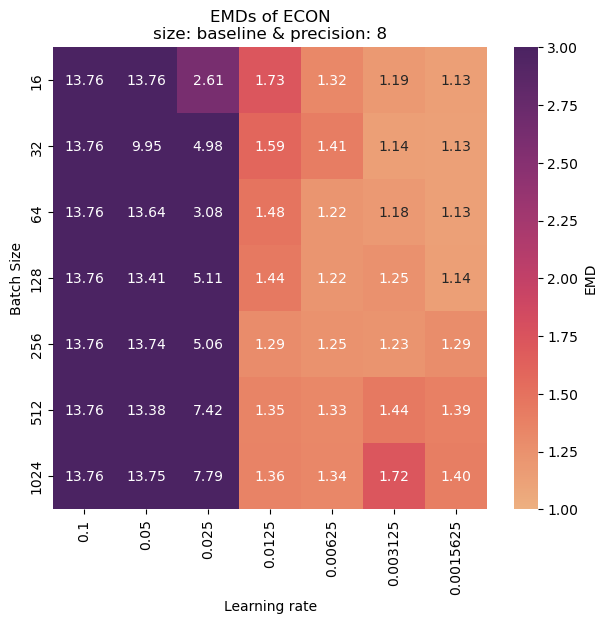

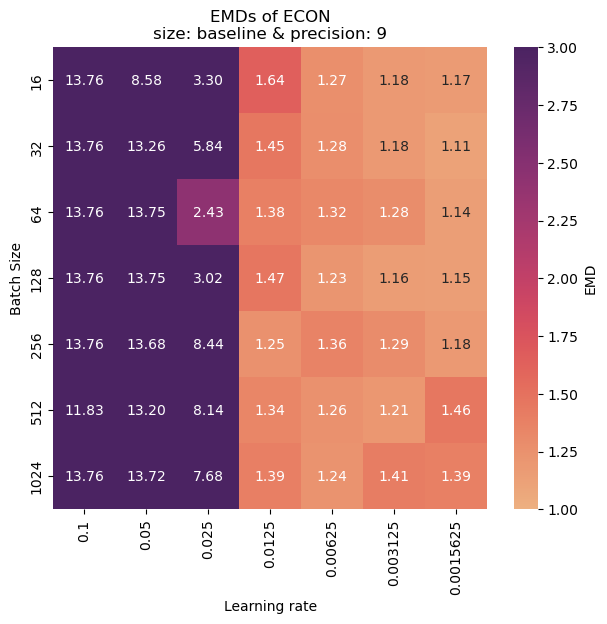

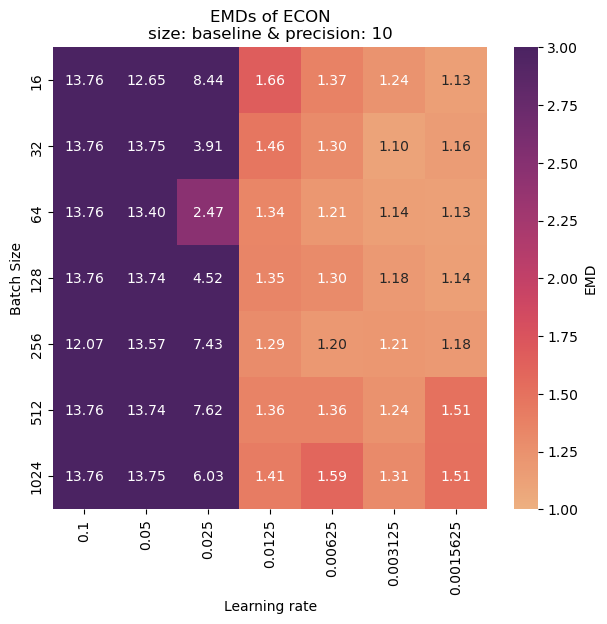

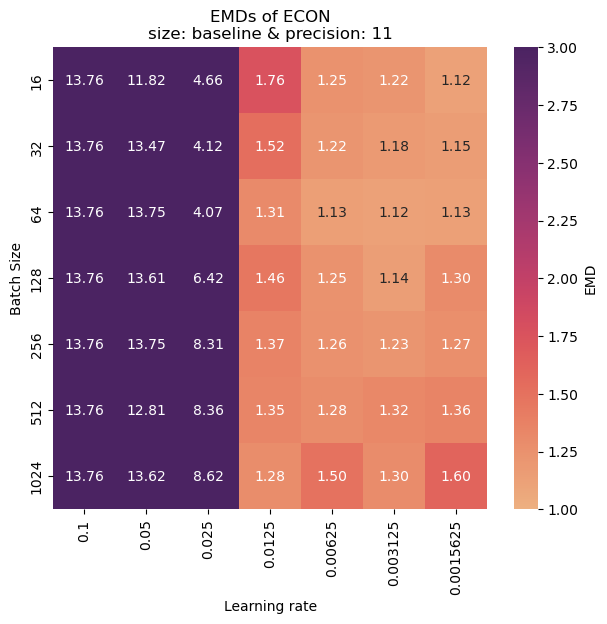

In [5]:
# plotting a heat map per layer
for p in precisions:
    EMD_matrix = np.zeros((len(batch_sizes), len(learning_rates)))
    for x, bs in enumerate(batch_sizes):
        for y, lr in enumerate(learning_rates):
            mean_EMD, _ = econ.get_model_index_and_relative_EMD(DATA_PATH, bs, lr, p, size)
            EMD_matrix[x, y] = mean_EMD
            
            
    EMD_matrix = pd.DataFrame(EMD_matrix, 
                              index=batch_sizes, 
                              columns=learning_rates)
    
    plot_2d_heatmap(EMD_matrix, 
                    f'EMDs of ECON\nsize: {size} & precision: {p}', 
                    (1, 3),
                    'Learning rate',
                    'Batch Size',
                    'EMD',
                    cmap='flare')

Let's remove high learning rates from next analysis:

In [6]:
learning_rates = [0.1, 0.05, 0.025, 0.0125, 0.00625, 0.003125, 0.0015625]

In [7]:
emd_distribution = []
for p in precisions:
    EMD_matrix = np.zeros((len(batch_sizes), len(learning_rates)))
    for x, bs in enumerate(batch_sizes):
        for y, lr in enumerate(learning_rates):
            mean_EMD, _ = econ.get_model_index_and_relative_EMD(DATA_PATH, bs, lr, p, size)
            EMD_matrix[x, y] = mean_EMD
            emd_distribution.append({
                'precision': p, 
                'EMD': mean_EMD,
                'batch_size': str(bs),
                'learning_rate': str(lr),
            })

In [8]:
emd_distribution_df = pd.DataFrame(emd_distribution)
emd_distribution_df = emd_distribution_df.sort_values(by='EMD', ascending=True)
emd_distribution_df.head(10)

precision       EMD batch_size learning_rate
404         10  1.104643         32      0.003125
223          6  1.105781        128     0.0015625
356          9  1.114145         32     0.0015625
447         11  1.120972         16     0.0015625
460         11  1.123161         64      0.003125
412         10  1.126236         64     0.0015625
307          8  1.127017         32     0.0015625
461         11  1.127617         64     0.0015625
314          8  1.127975         64     0.0015625
265          7  1.132471         64     0.0015625

## Scientific Benchmark

In [9]:
precisions = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
noise_type = 'gaussian'

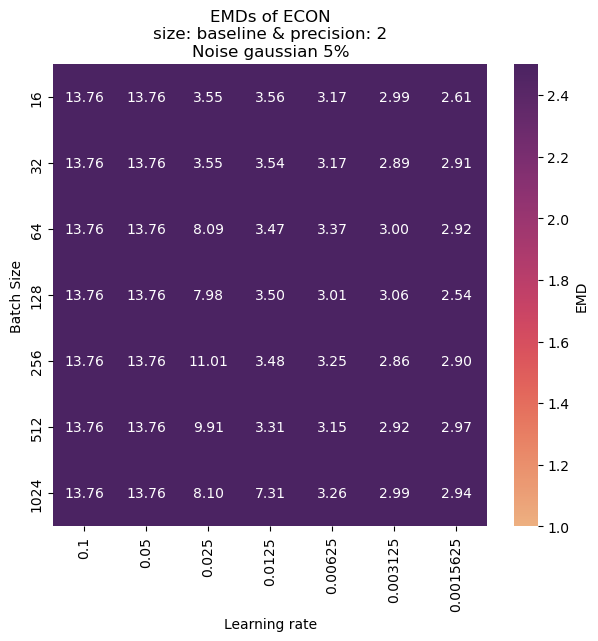

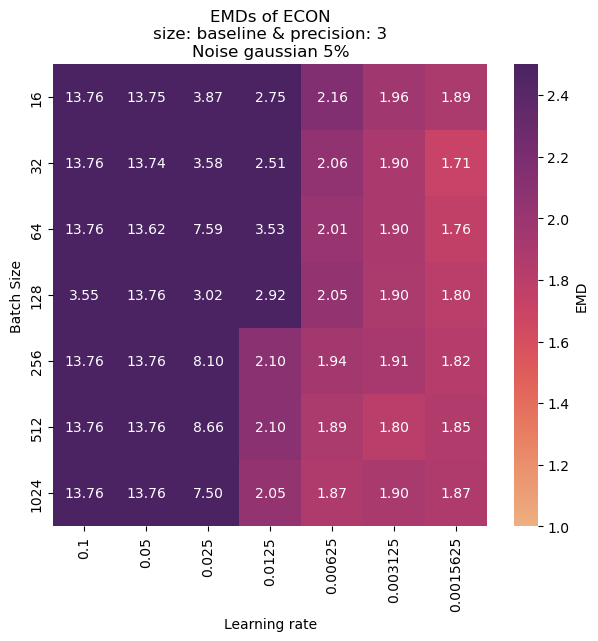

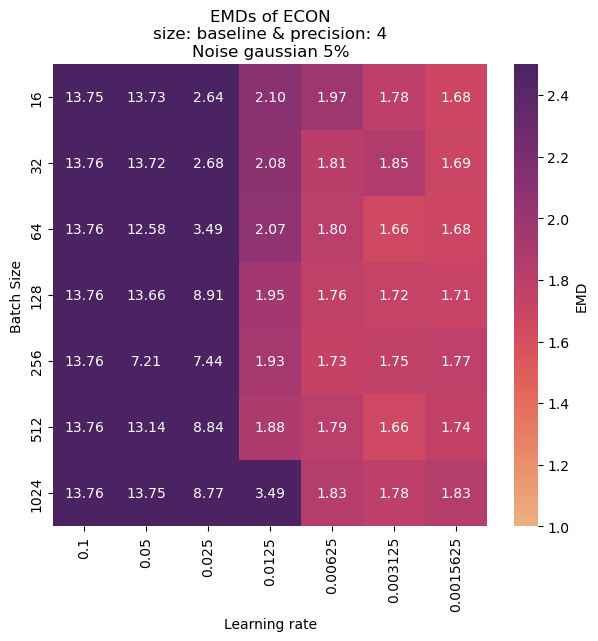

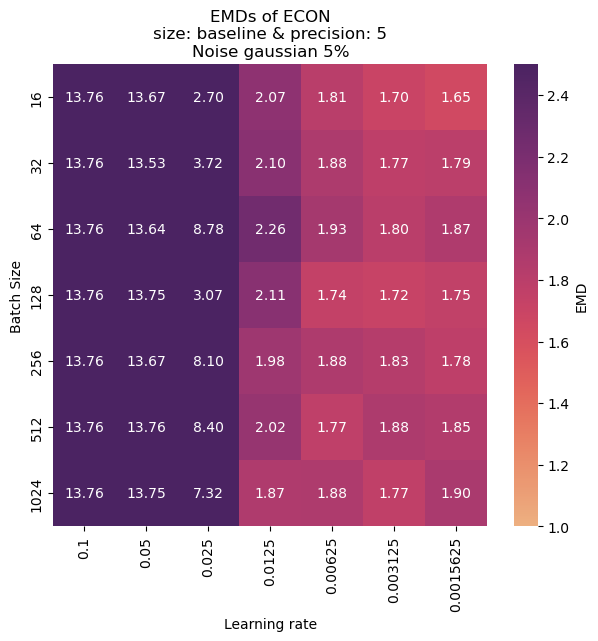

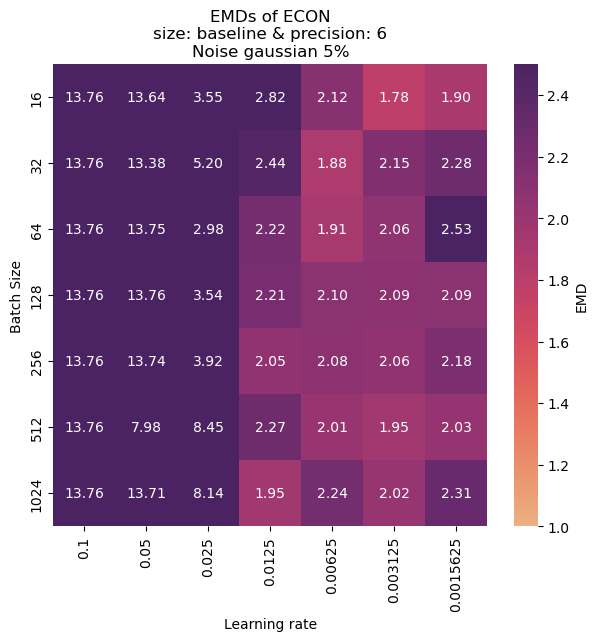

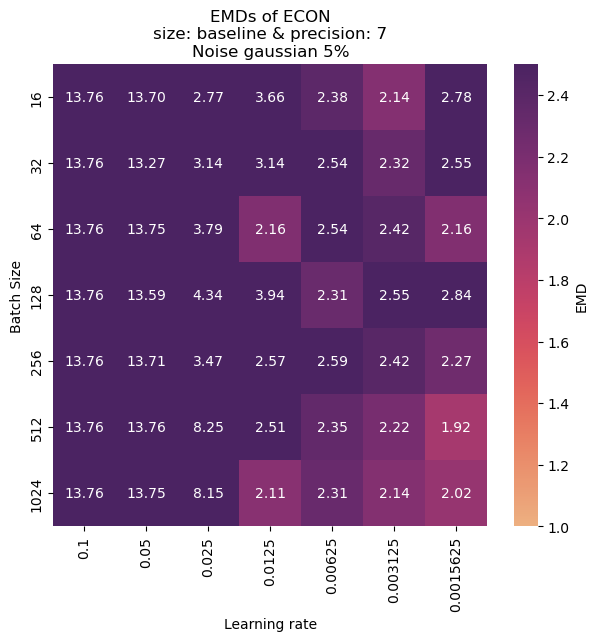

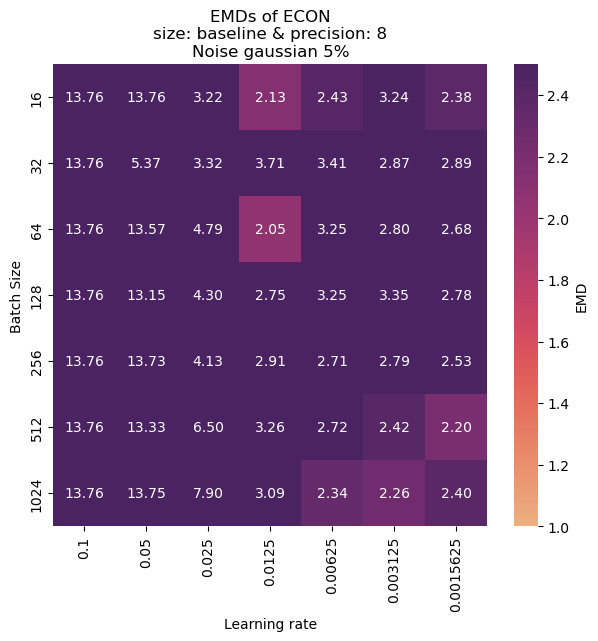

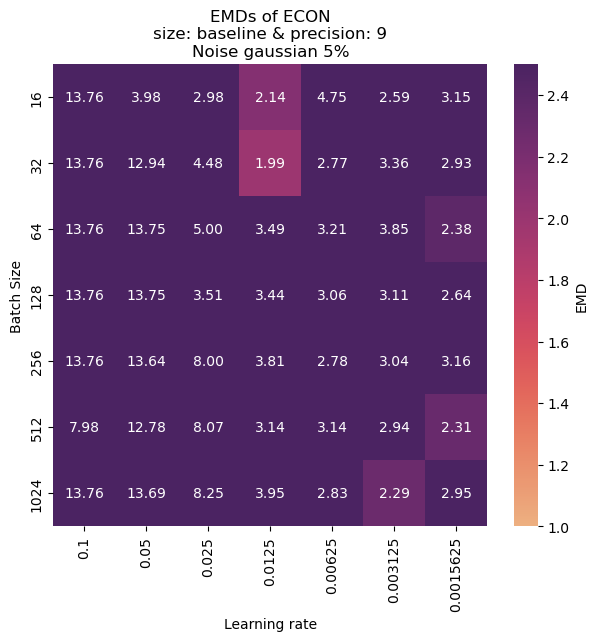

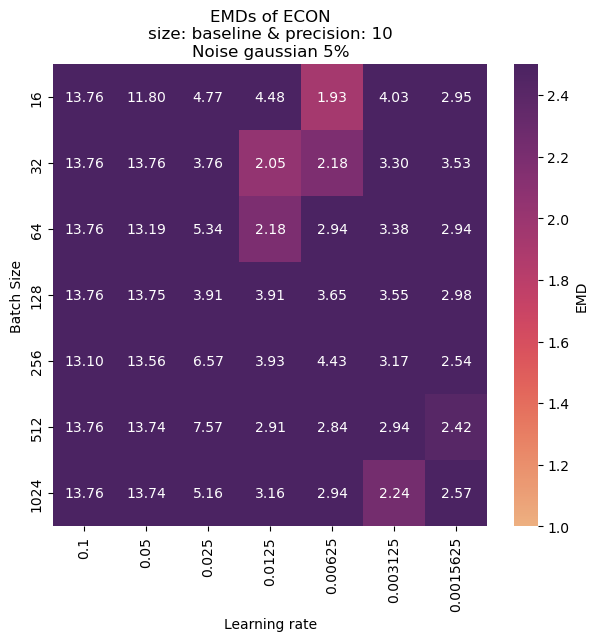

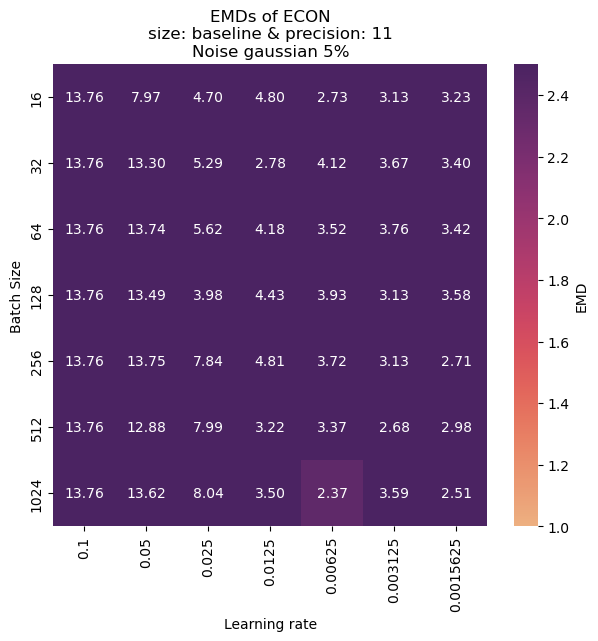

In [10]:
emd_distribution = []
for p in precisions:
    EMD_matrix = np.zeros((len(batch_sizes), len(learning_rates)))
    for x, bs in enumerate(batch_sizes):
        for y, lr in enumerate(learning_rates):
            # get teh noise values
            noise_emd_5 = econ.get_emd_with_noise(DATA_PATH, bs, lr, p, size, noise_type, 5)
            noise_emd_10 = econ.get_emd_with_noise(DATA_PATH, bs, lr, p, size, noise_type, 10)
            noise_emd_15 = econ.get_emd_with_noise(DATA_PATH, bs, lr, p, size, noise_type, 15)
            noise_emd_20 = econ.get_emd_with_noise(DATA_PATH, bs, lr, p, size, noise_type, 20)
            original_emd, _ = econ.get_model_index_and_relative_EMD(DATA_PATH, bs, lr, p, size)
            
            # build the matrix for the heatmap
            EMD_matrix[x, y] = noise_emd_5
            
            # store the values for the plots
            emd_distribution.append({
                'precision': p, 
                'emd': original_emd,
                # 'noise 5%': (noise_emd_5 - original_emd) * 100 / original_emd,
                # 'noise 10%': (noise_emd_10 - original_emd) * 100 / original_emd,
                # 'noise 15%': (noise_emd_15 - original_emd) * 100 / original_emd,
                # 'noise 20%': (noise_emd_20 - original_emd) * 100 / original_emd,
                'noise 5%': noise_emd_5,
                'noise 10%': noise_emd_10,
                'noise 15%': noise_emd_15,
                'noise 20%': noise_emd_20,
                'batch_size': str(bs),
                'learning_rate': str(lr),
                'precision': p,
            })
            
    # heat map of the EMD with noise as input per precision
    EMD_matrix = pd.DataFrame(EMD_matrix, 
                              index=batch_sizes, 
                              columns=learning_rates)
    
    plot_2d_heatmap(EMD_matrix, 
                    f'EMDs of ECON\nsize: {size} & precision: {p}\n' \
                    f'Noise {noise_type} 5%', 
                    (1, 2.5),
                    'Learning rate',
                    'Batch Size',
                    'EMD',
                    cmap='flare')
        

In [11]:
emd_distribution_df = pd.DataFrame(emd_distribution)
# export the CSV
emd_distribution_df.to_csv("./results/econ/noise.csv", index=False)

We want to plot the heatmap based on the precision, because the batch size is not correlated with the EMD and the noise.

--------------------------------------------------------------------------------


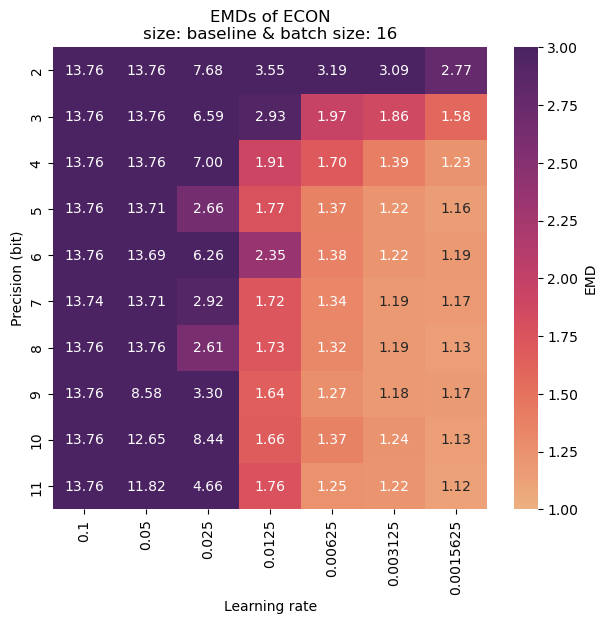

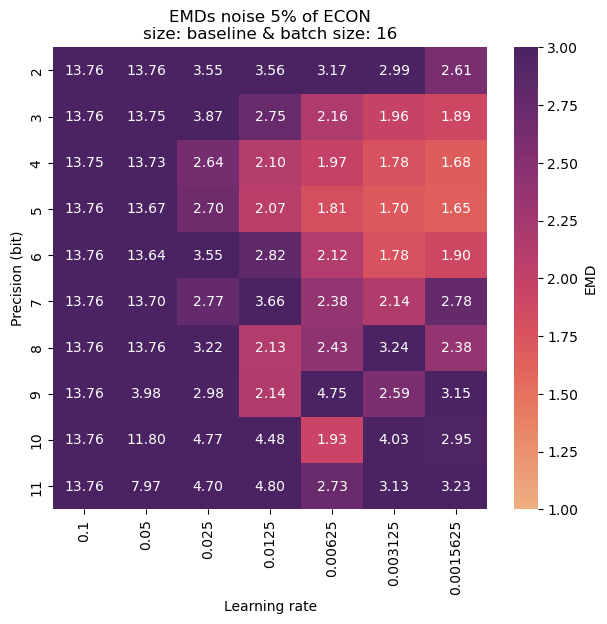

--------------------------------------------------------------------------------


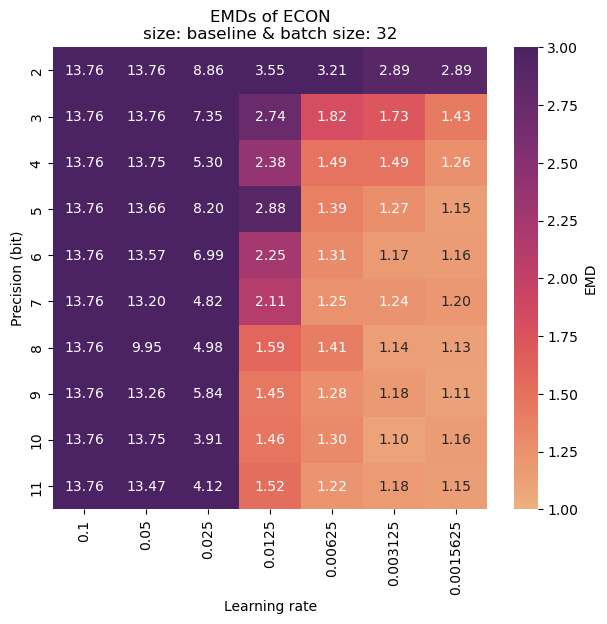

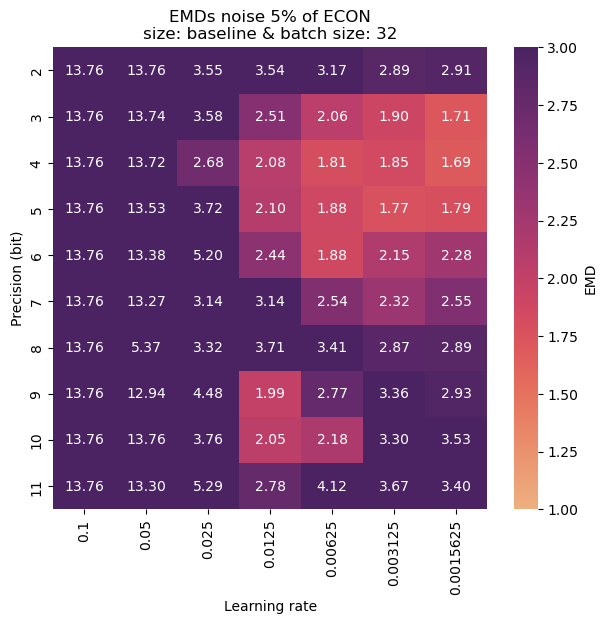

--------------------------------------------------------------------------------


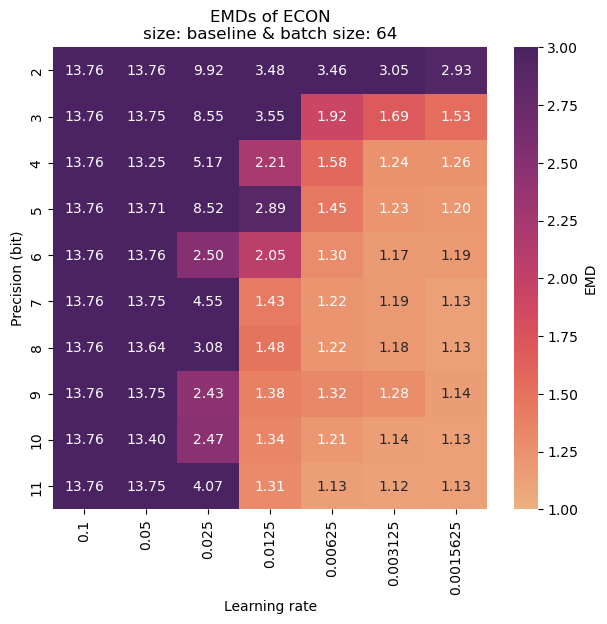

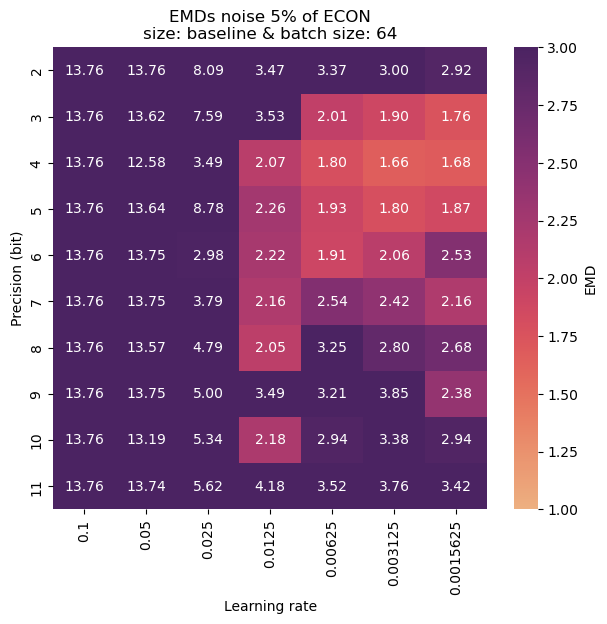

--------------------------------------------------------------------------------


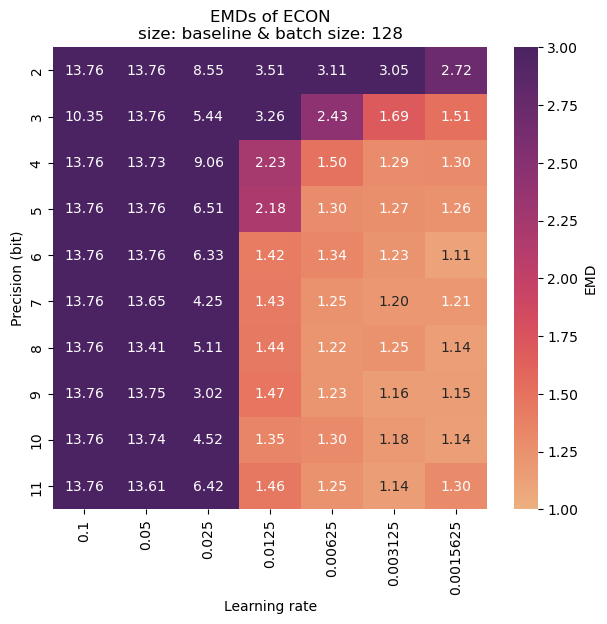

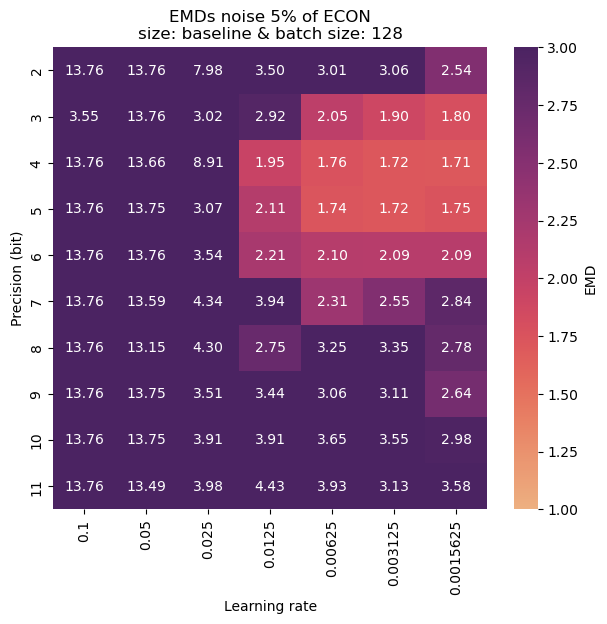

--------------------------------------------------------------------------------


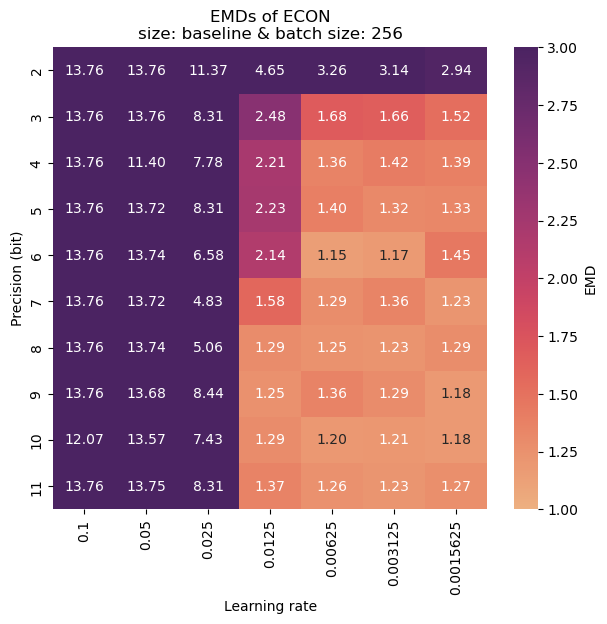

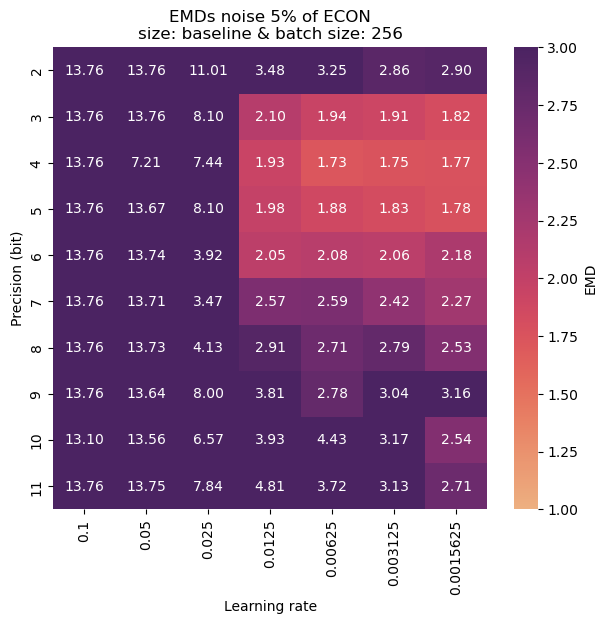

--------------------------------------------------------------------------------


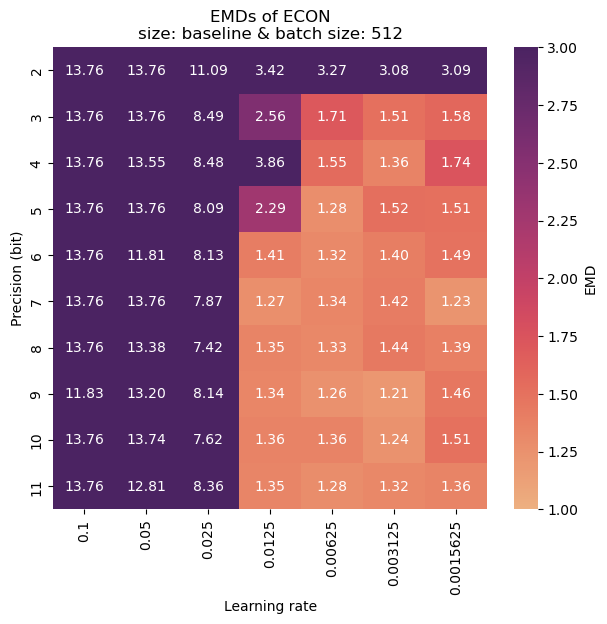

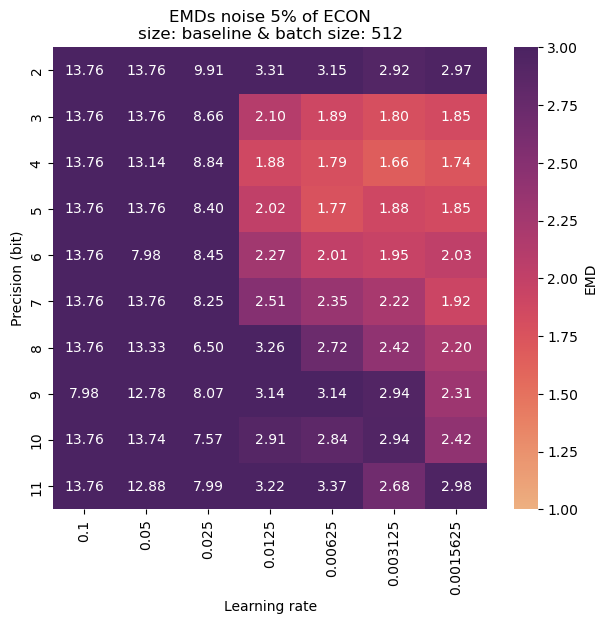

--------------------------------------------------------------------------------


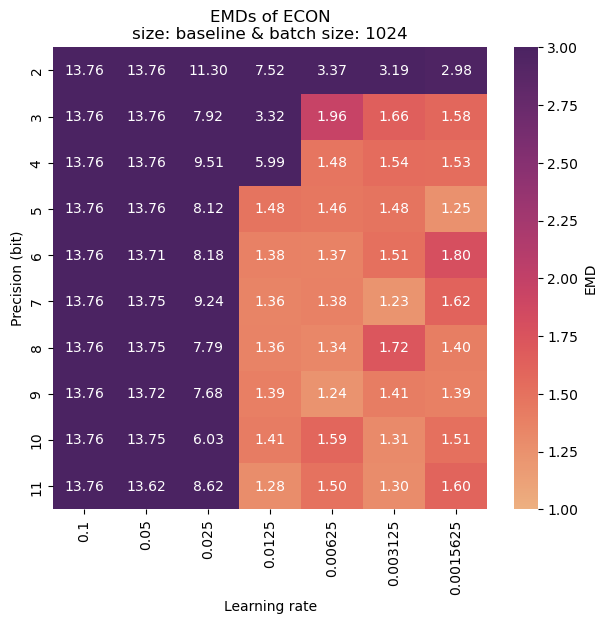

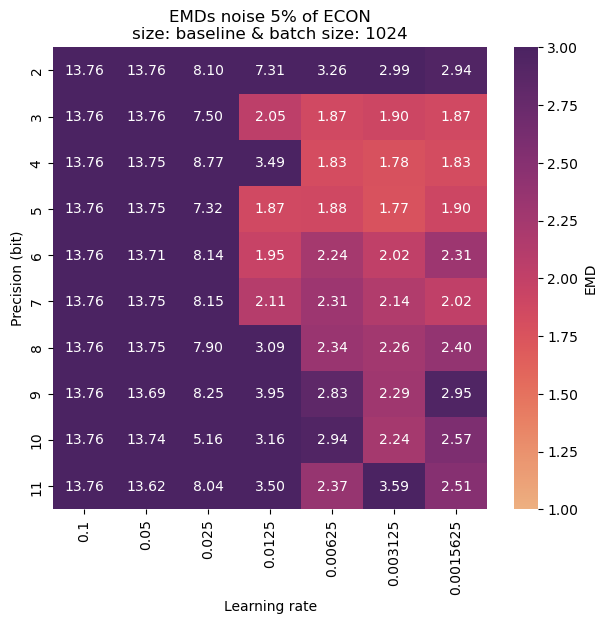

In [12]:

for bs in batch_sizes:
    matrix = np.zeros((len(precisions), len(learning_rates)))
    noise_matrix = np.zeros((len(precisions), len(learning_rates)))
    for y, lr in enumerate(learning_rates):
        for x, p in enumerate(precisions):
            
            # get the performances with and without noise
            mean_emd, _ = econ.get_model_index_and_relative_EMD(DATA_PATH, bs, lr, p, size)
            noise_emd_5 = econ.get_emd_with_noise(DATA_PATH, bs, lr, p, size, noise_type, 5)
            
            # build the heatmap matrix
            matrix[x, y] = mean_emd
            noise_matrix[x, y] = noise_emd_5

            
    # plot the heatmaps per precision
    matrix = pd.DataFrame(matrix, 
                          index=precisions, 
                          columns=learning_rates)
    noise_matrix = pd.DataFrame(noise_matrix, 
                          index=precisions, 
                          columns=learning_rates)
    print(80*'-')
    plot_2d_heatmap(matrix, 
                    f'EMDs of ECON\nsize: {size} & batch size: {bs}', 
                    (1, 3),
                    'Learning rate',
                    'Precision (bit)',
                    'EMD',
                    cmap='flare')
    
    plot_2d_heatmap(noise_matrix, 
                    f'EMDs noise 5% of ECON\nsize: {size} & batch size: {bs}', 
                    (1, 3),
                    'Learning rate',
                    'Precision (bit)',
                    'EMD',
                    cmap='flare')
    

In [13]:
top_noise_df = emd_distribution_df.sort_values(by='emd', ascending=True)
top_noise_df.head(10)

precision       emd  noise 5%  noise 10%  noise 15%  noise 20%  \
404         10  1.104643  3.295514   3.608166   3.627738   3.625013   
223          6  1.105781  2.092937   3.006155   3.534956   3.847934   
356          9  1.114145  2.930733   3.458393   3.635916   3.713881   
447         11  1.120972  3.225034   3.688270   3.804184   3.845747   
460         11  1.123161  3.758025   3.925178   3.953398   3.956901   
412         10  1.126236  2.939933   3.599533   3.833584   3.948925   
307          8  1.127017  2.892940   3.398102   3.557063   3.627581   
461         11  1.127617  3.419863   3.819421   3.957435   4.023776   
314          8  1.127975  2.684867   3.474687   3.793486   3.931022   
265          7  1.132471  2.158104   3.113376   3.681315   4.003596   

    batch_size learning_rate  
404         32      0.003125  
223        128     0.0015625  
356         32     0.0015625  
447         16     0.0015625  
460         64      0.003125  
412         64     0.0015625  
307         32     0.0015625  
461         64     0.0015625  
314         64     0.0015625  
265         64     0.0015625

# RN08 (TinyResNet)
Computer vision tasks trained on CIFAR10

In [14]:
# search space
batch_sizes = [16, 32, 64, 128, 256, 512, 1024]
learning_rates = [0.1, 0.05, 0.025, 0.0125, 0.00625, 0.003125, 0.0015625]
precisions = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [23]:
DATA_PATH="/data/tbaldi/work/checkpoint/"   
DATASET_DIR = "/data/tbaldi/work/loss_landscape_taxonomy/data/RN08/"

## Accuracy results

File not found! (/data/tbaldi/work/checkpoint/bs32_lr0.05/RN08_2b/accuracy_1.txt)
File not found! (/data/tbaldi/work/checkpoint/bs32_lr0.00625/RN08_2b/accuracy_1.txt)
File not found! (/data/tbaldi/work/checkpoint/bs64_lr0.025/RN08_2b/accuracy_1.txt)
File not found! (/data/tbaldi/work/checkpoint/bs64_lr0.0125/RN08_2b/accuracy_1.txt)
File not found! (/data/tbaldi/work/checkpoint/bs128_lr0.05/RN08_2b/accuracy_1.txt)
File not found! (/data/tbaldi/work/checkpoint/bs128_lr0.00625/RN08_2b/accuracy_1.txt)
File not found! (/data/tbaldi/work/checkpoint/bs256_lr0.003125/RN08_2b/accuracy_1.txt)
File not found! (/data/tbaldi/work/checkpoint/bs512_lr0.0015625/RN08_2b/accuracy_1.txt)
File not found! (/data/tbaldi/work/checkpoint/bs1024_lr0.003125/RN08_2b/accuracy_1.txt)
File not found! (/data/tbaldi/work/checkpoint/bs1024_lr0.0015625/RN08_2b/accuracy_1.txt)


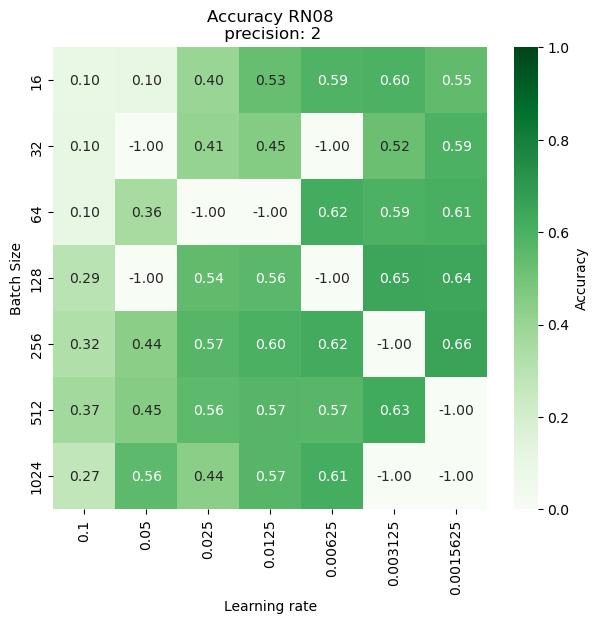

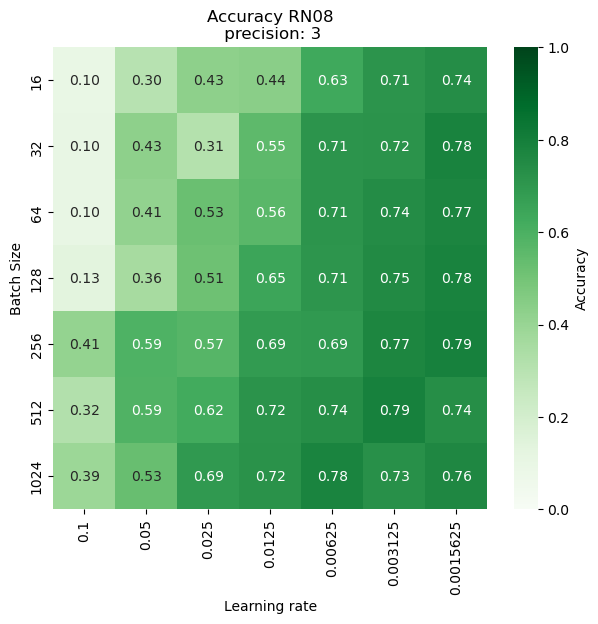

File not found! (/data/tbaldi/work/checkpoint/bs1024_lr0.00625/RN08_4b/accuracy_1.txt)


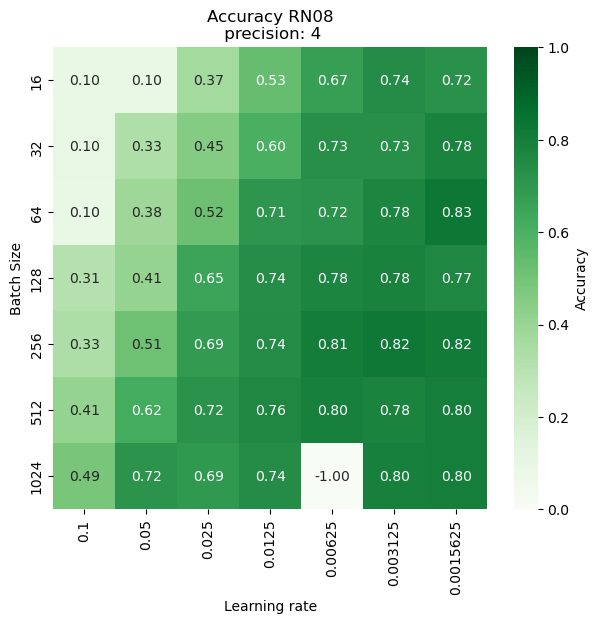

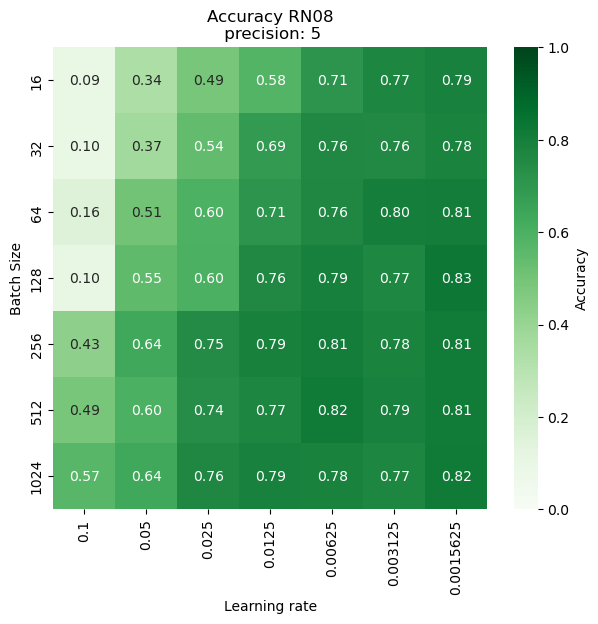

File not found! (/data/tbaldi/work/checkpoint/bs1024_lr0.00625/RN08_6b/accuracy_1.txt)


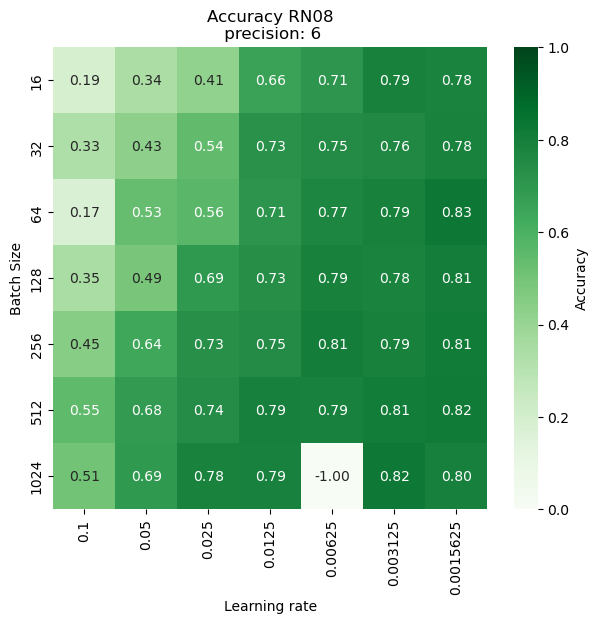

File not found! (/data/tbaldi/work/checkpoint/bs1024_lr0.00625/RN08_7b/accuracy_1.txt)


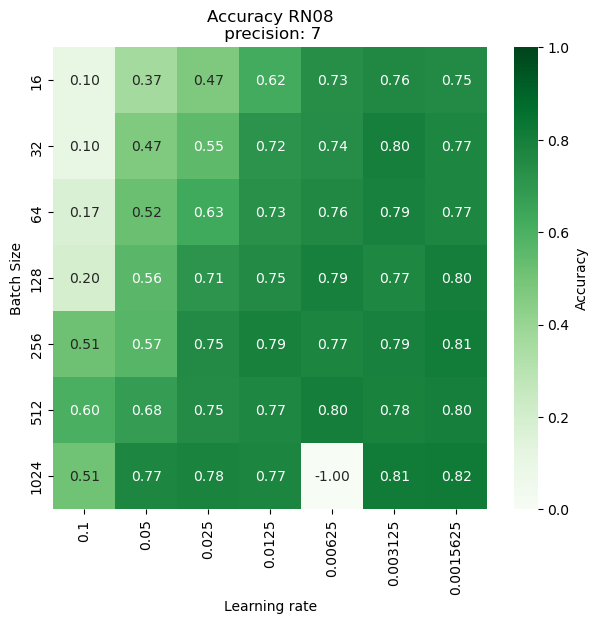

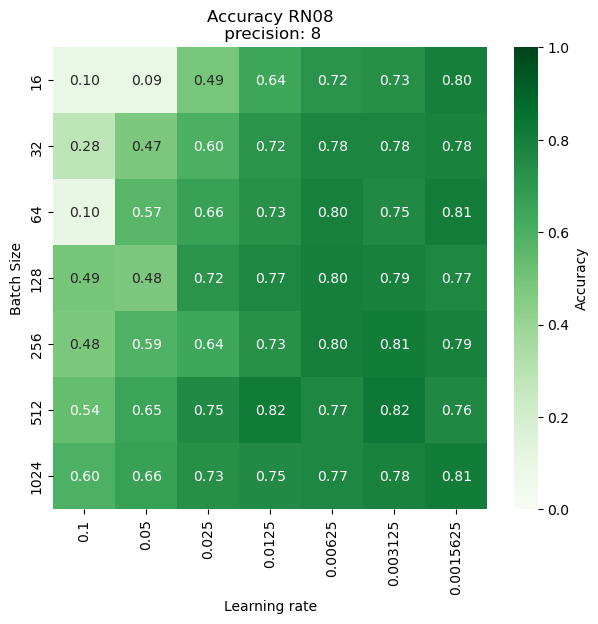

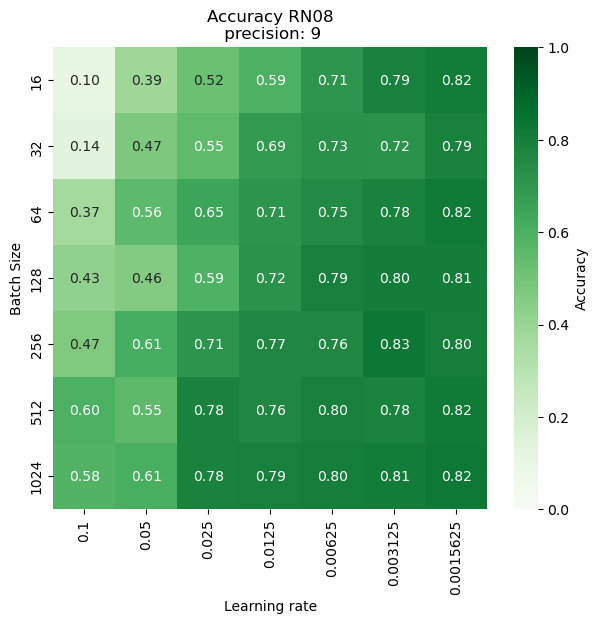

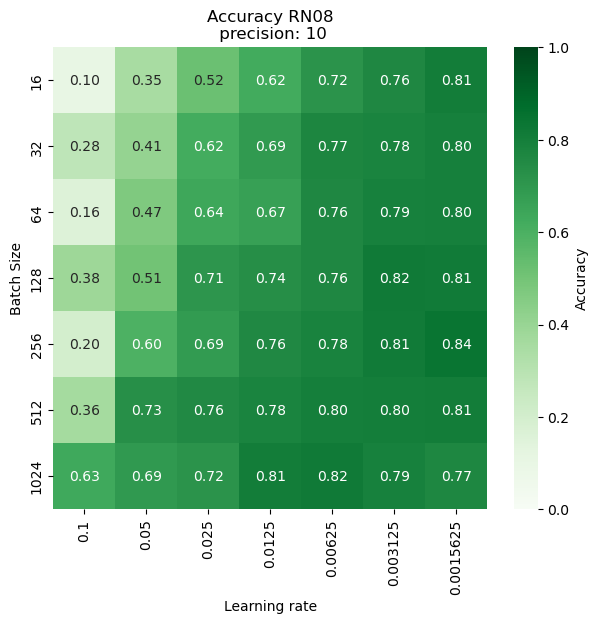

File not found! (/data/tbaldi/work/checkpoint/bs1024_lr0.00625/RN08_11b/accuracy_1.txt)


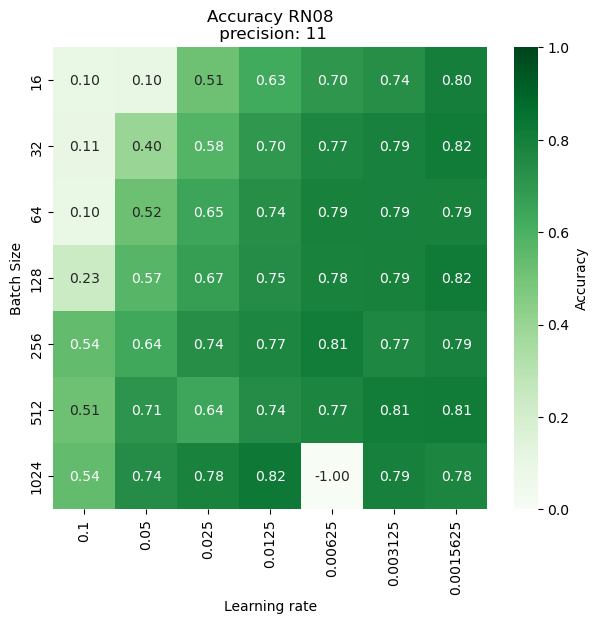

In [24]:
# plotting a heat map per layer
for p in precisions:
    matrix = np.zeros((len(batch_sizes), len(learning_rates)))
    for x, bs in enumerate(batch_sizes):
        for y, lr in enumerate(learning_rates):
            acc = rn08.get_accuracy(DATA_PATH, bs, lr, p)
            matrix[x, y] = acc
            
            
    matrix = pd.DataFrame(matrix, 
                          index=batch_sizes, 
                          columns=learning_rates)
    
    plot_2d_heatmap(matrix, 
                    f'Accuracy RN08\n precision: {p}', 
                    (0, 1),
                    'Learning rate',
                    'Batch Size',
                    'Accuracy',
                    cmap='Greens')

## Scientific Benchmark

In [25]:

noise_type = "pixelate"
precisions = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

/data/tbaldi/work/checkpoint/bs16_lr0.1/RN08_2b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs16_lr0.05/RN08_2b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs16_lr0.025/RN08_2b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs16_lr0.0125/RN08_2b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs16_lr0.00625/RN08_2b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs16_lr0.003125/RN08_2b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs16_lr0.0015625/RN08_2b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs32_lr0.1/RN08_2b/accuracy_pixelate.txt not found!
File not found! (/data/tbaldi/work/checkpoint/bs32_lr0.05/RN08_2b/accuracy_1.txt)
/data/tbaldi/work/checkpoint/bs32_lr0.05/RN08_2b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs32_lr0.025/RN08_2b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs32_lr0.0125/RN08_2b/accuracy_pixelate.txt not found!


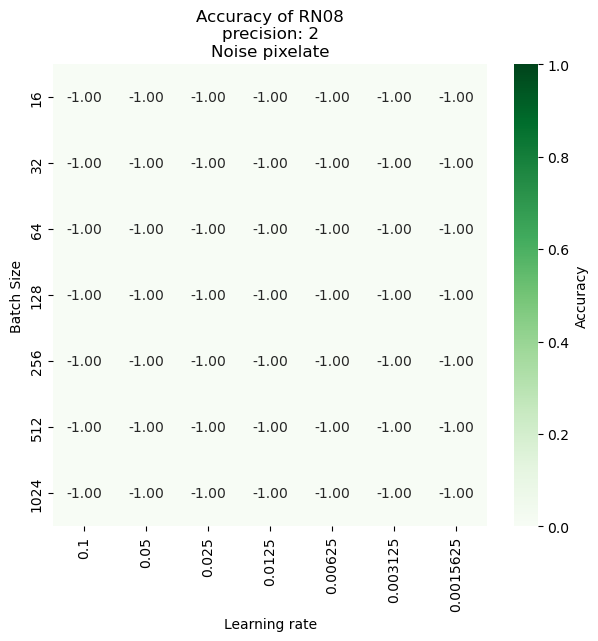

/data/tbaldi/work/checkpoint/bs16_lr0.1/RN08_3b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs16_lr0.05/RN08_3b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs16_lr0.025/RN08_3b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs16_lr0.0125/RN08_3b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs16_lr0.00625/RN08_3b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs16_lr0.003125/RN08_3b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs16_lr0.0015625/RN08_3b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs32_lr0.1/RN08_3b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs32_lr0.05/RN08_3b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs32_lr0.025/RN08_3b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs32_lr0.0125/RN08_3b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs32_lr0.00625/RN08_3b/accuracy_pixelate.txt not foun

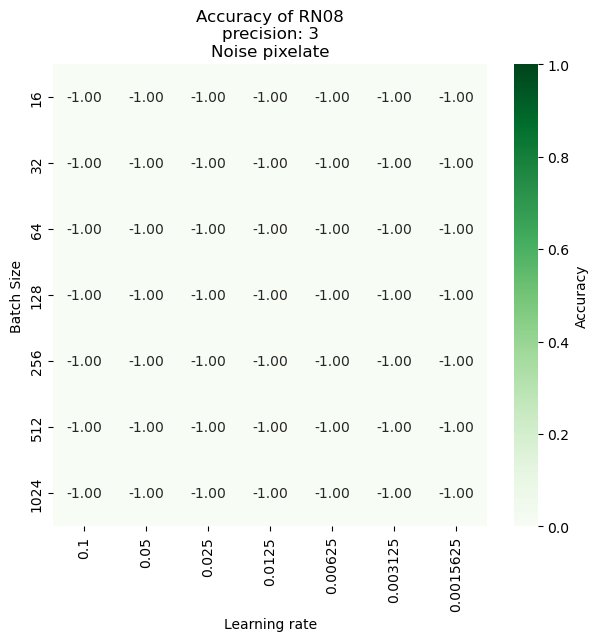

/data/tbaldi/work/checkpoint/bs16_lr0.1/RN08_4b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs16_lr0.05/RN08_4b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs16_lr0.025/RN08_4b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs16_lr0.0125/RN08_4b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs16_lr0.00625/RN08_4b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs16_lr0.003125/RN08_4b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs16_lr0.0015625/RN08_4b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs32_lr0.1/RN08_4b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs32_lr0.05/RN08_4b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs32_lr0.025/RN08_4b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs32_lr0.0125/RN08_4b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs32_lr0.00625/RN08_4b/accuracy_pixelate.txt not foun

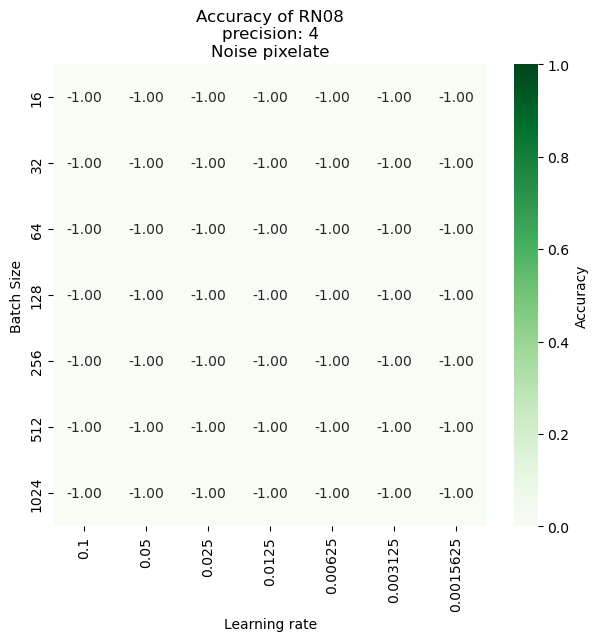

/data/tbaldi/work/checkpoint/bs16_lr0.1/RN08_5b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs16_lr0.05/RN08_5b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs16_lr0.025/RN08_5b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs16_lr0.0125/RN08_5b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs16_lr0.00625/RN08_5b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs16_lr0.003125/RN08_5b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs16_lr0.0015625/RN08_5b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs32_lr0.1/RN08_5b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs32_lr0.05/RN08_5b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs32_lr0.025/RN08_5b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs32_lr0.0125/RN08_5b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs32_lr0.00625/RN08_5b/accuracy_pixelate.txt not foun

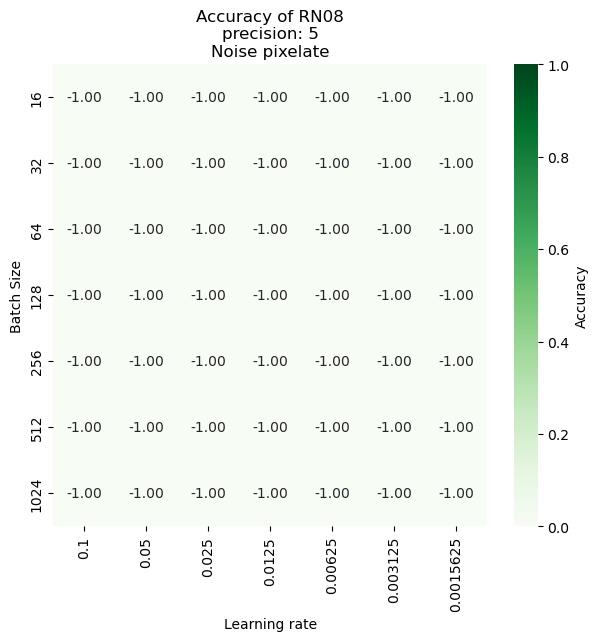

/data/tbaldi/work/checkpoint/bs16_lr0.1/RN08_6b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs16_lr0.05/RN08_6b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs16_lr0.025/RN08_6b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs16_lr0.0125/RN08_6b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs16_lr0.00625/RN08_6b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs16_lr0.003125/RN08_6b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs16_lr0.0015625/RN08_6b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs32_lr0.1/RN08_6b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs32_lr0.05/RN08_6b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs32_lr0.025/RN08_6b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs32_lr0.0125/RN08_6b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs32_lr0.00625/RN08_6b/accuracy_pixelate.txt not foun

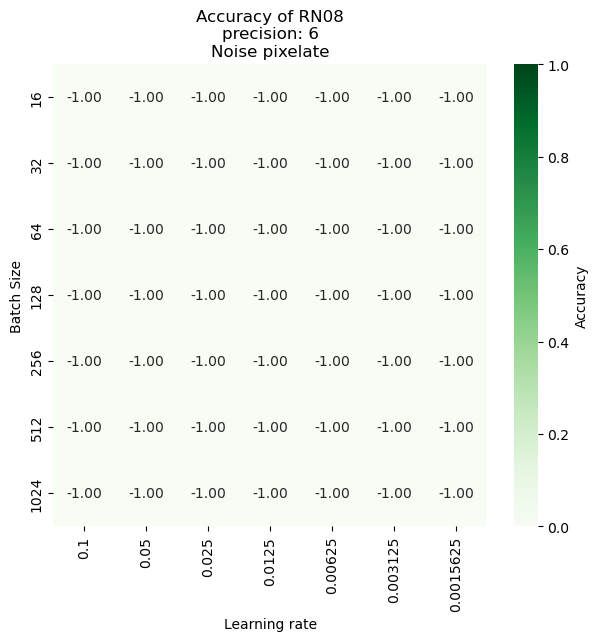

/data/tbaldi/work/checkpoint/bs16_lr0.1/RN08_7b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs16_lr0.05/RN08_7b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs16_lr0.025/RN08_7b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs16_lr0.0125/RN08_7b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs16_lr0.00625/RN08_7b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs16_lr0.003125/RN08_7b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs16_lr0.0015625/RN08_7b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs32_lr0.1/RN08_7b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs32_lr0.05/RN08_7b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs32_lr0.025/RN08_7b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs32_lr0.0125/RN08_7b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs32_lr0.00625/RN08_7b/accuracy_pixelate.txt not foun

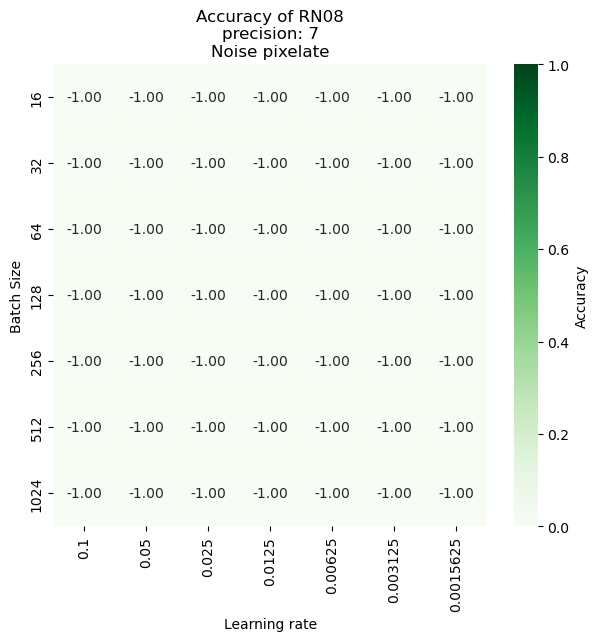

/data/tbaldi/work/checkpoint/bs16_lr0.1/RN08_8b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs16_lr0.05/RN08_8b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs16_lr0.025/RN08_8b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs16_lr0.0125/RN08_8b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs16_lr0.00625/RN08_8b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs16_lr0.003125/RN08_8b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs16_lr0.0015625/RN08_8b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs32_lr0.1/RN08_8b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs32_lr0.05/RN08_8b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs32_lr0.025/RN08_8b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs32_lr0.0125/RN08_8b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs32_lr0.00625/RN08_8b/accuracy_pixelate.txt not foun

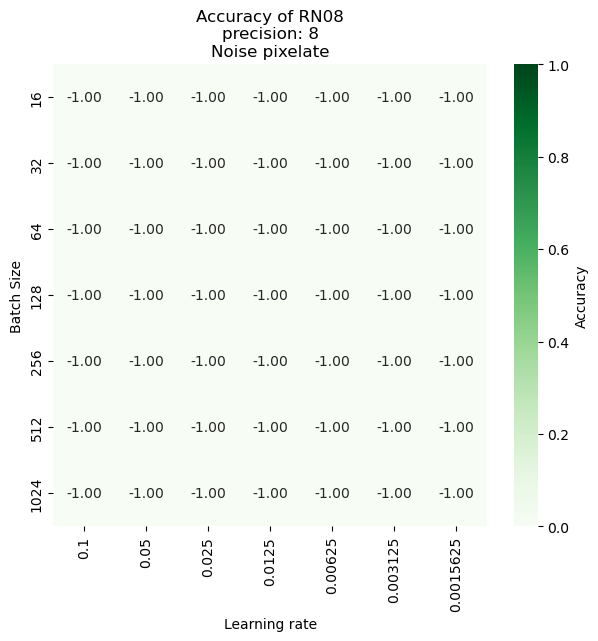

/data/tbaldi/work/checkpoint/bs16_lr0.1/RN08_9b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs16_lr0.05/RN08_9b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs16_lr0.025/RN08_9b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs16_lr0.0125/RN08_9b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs16_lr0.00625/RN08_9b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs16_lr0.003125/RN08_9b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs16_lr0.0015625/RN08_9b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs32_lr0.1/RN08_9b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs32_lr0.05/RN08_9b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs32_lr0.025/RN08_9b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs32_lr0.0125/RN08_9b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs32_lr0.00625/RN08_9b/accuracy_pixelate.txt not foun

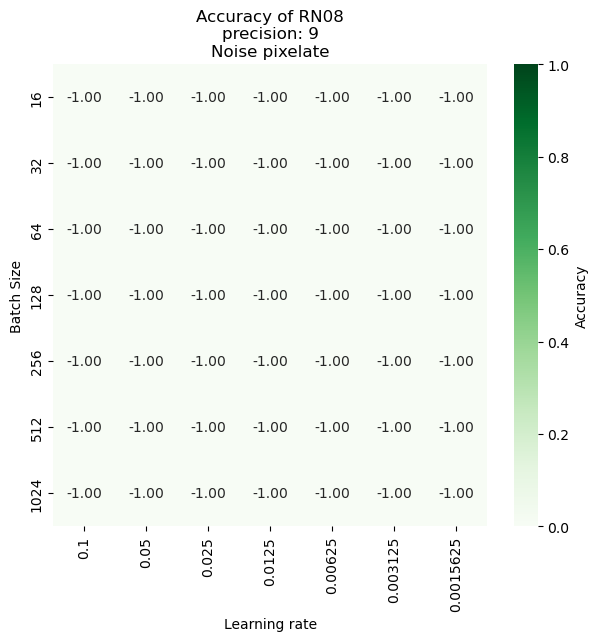

/data/tbaldi/work/checkpoint/bs16_lr0.1/RN08_10b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs16_lr0.05/RN08_10b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs16_lr0.025/RN08_10b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs16_lr0.0125/RN08_10b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs16_lr0.00625/RN08_10b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs16_lr0.003125/RN08_10b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs16_lr0.0015625/RN08_10b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs32_lr0.1/RN08_10b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs32_lr0.05/RN08_10b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs32_lr0.025/RN08_10b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs32_lr0.0125/RN08_10b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs32_lr0.00625/RN08_10b/accuracy_pixelate.

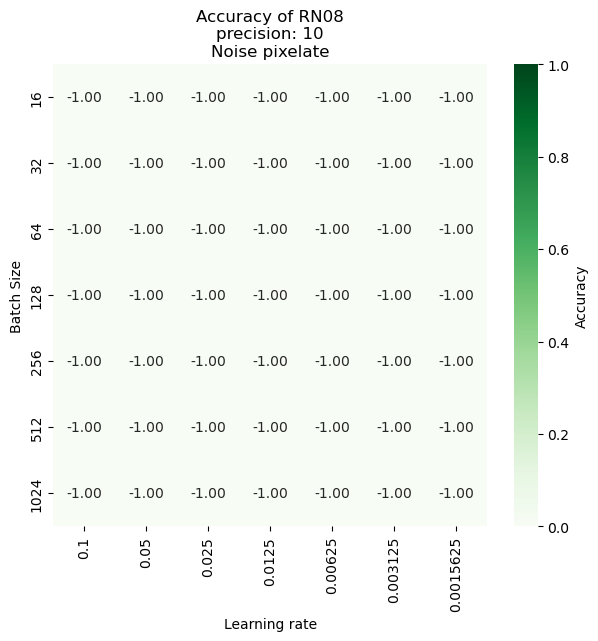

/data/tbaldi/work/checkpoint/bs16_lr0.1/RN08_11b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs16_lr0.05/RN08_11b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs16_lr0.025/RN08_11b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs16_lr0.0125/RN08_11b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs16_lr0.00625/RN08_11b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs16_lr0.003125/RN08_11b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs16_lr0.0015625/RN08_11b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs32_lr0.1/RN08_11b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs32_lr0.05/RN08_11b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs32_lr0.025/RN08_11b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs32_lr0.0125/RN08_11b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs32_lr0.00625/RN08_11b/accuracy_pixelate.

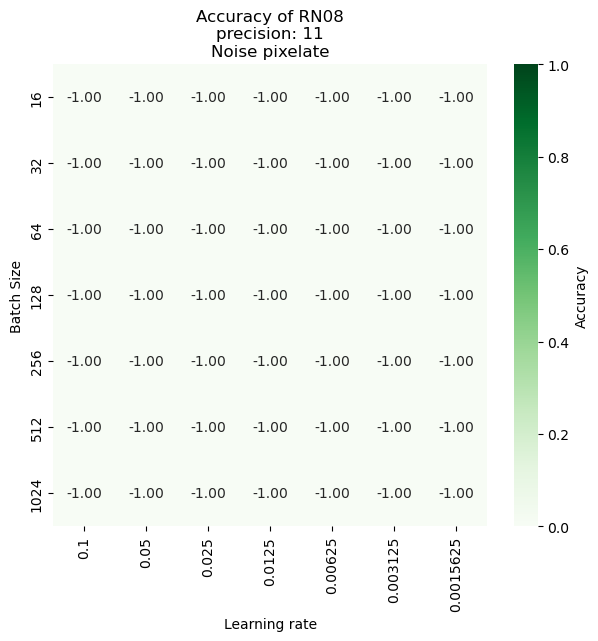

In [26]:
acc_distribution = []
for p in precisions:
    matrix = np.zeros((len(batch_sizes), len(learning_rates)))
    for x, bs in enumerate(batch_sizes):
        for y, lr in enumerate(learning_rates):
            acc = rn08.get_accuracy(DATA_PATH, bs, lr, p)
            noise_acc = rn08.get_accuracy_with_noise(DATA_PATH, bs, lr, p, noise_type)
            
            matrix[x, y] = noise_acc
            
            acc_distribution.append({
                'precision': p, 
                'accuracy': acc,
                'noise accuracy': noise_acc,
                'batch_size': str(bs),
                'learning_rate': str(lr),
                'precision': p,
            })
            
    matrix = pd.DataFrame(matrix,
                          index=batch_sizes,
                          columns=learning_rates)
    
    plot_2d_heatmap(matrix, 
                    f'Accuracy of RN08\nprecision: {p}\n' \
                    f'Noise {noise_type}', 
                    (0, 1),
                    'Learning rate',
                    'Batch Size',
                    'Accuracy',
                    cmap='Greens')

In [27]:
acc_distribution_df = pd.DataFrame(acc_distribution)
# export the CSV
acc_distribution_df.to_csv("./results/rn08/noise.csv", index=False)

/data/tbaldi/work/checkpoint/bs16_lr0.1/RN08_2b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs16_lr0.1/RN08_3b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs16_lr0.1/RN08_4b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs16_lr0.1/RN08_5b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs16_lr0.1/RN08_6b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs16_lr0.1/RN08_7b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs16_lr0.1/RN08_8b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs16_lr0.1/RN08_9b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs16_lr0.1/RN08_10b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs16_lr0.1/RN08_11b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs16_lr0.05/RN08_2b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs16_lr0.05/RN08_3b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkp

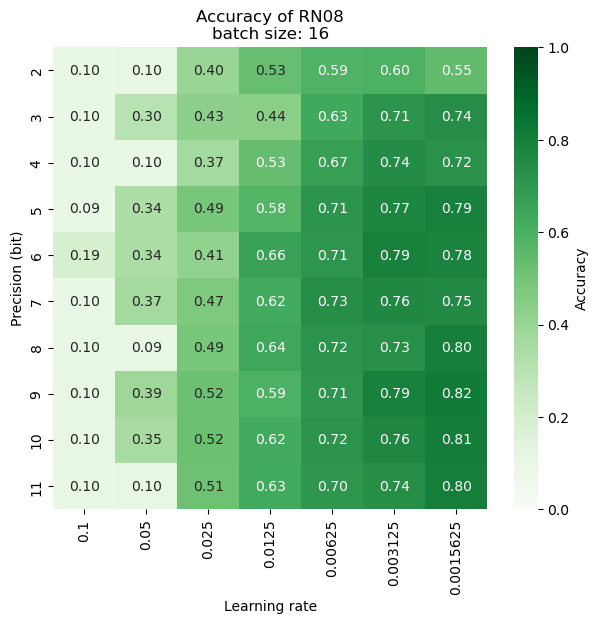

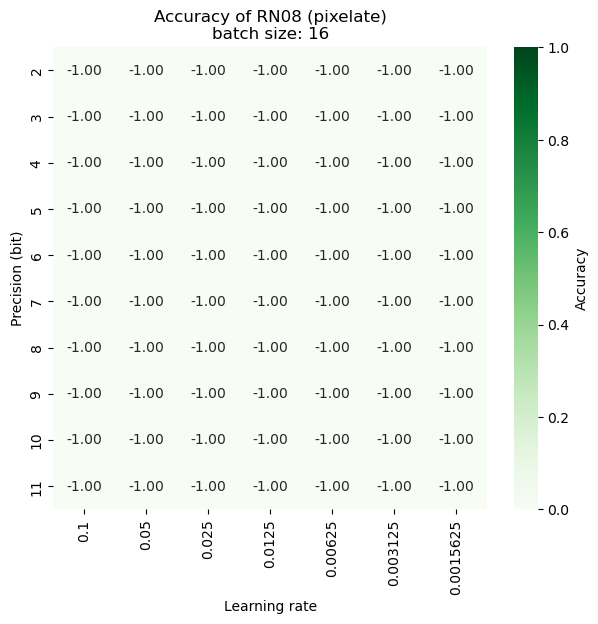

/data/tbaldi/work/checkpoint/bs32_lr0.1/RN08_2b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs32_lr0.1/RN08_3b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs32_lr0.1/RN08_4b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs32_lr0.1/RN08_5b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs32_lr0.1/RN08_6b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs32_lr0.1/RN08_7b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs32_lr0.1/RN08_8b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs32_lr0.1/RN08_9b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs32_lr0.1/RN08_10b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs32_lr0.1/RN08_11b/accuracy_pixelate.txt not found!
File not found! (/data/tbaldi/work/checkpoint/bs32_lr0.05/RN08_2b/accuracy_1.txt)
/data/tbaldi/work/checkpoint/bs32_lr0.05/RN08_2b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkp

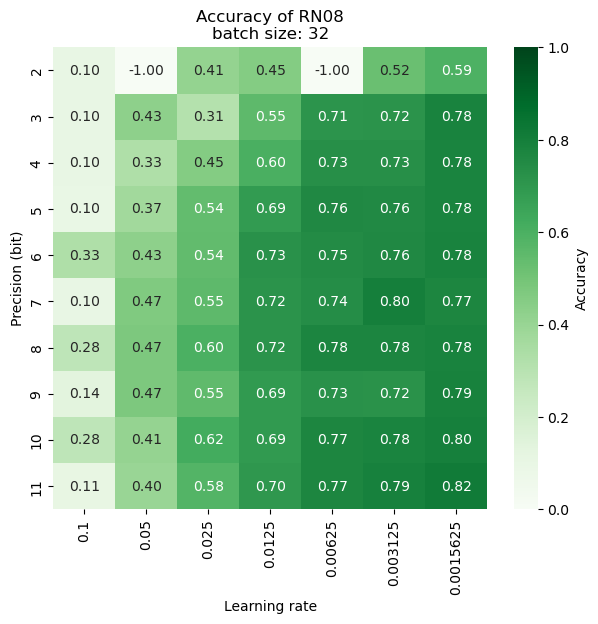

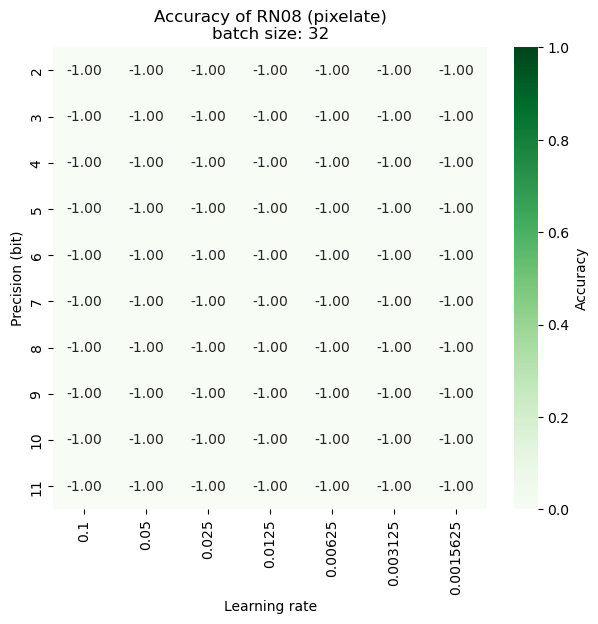

/data/tbaldi/work/checkpoint/bs64_lr0.1/RN08_2b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs64_lr0.1/RN08_3b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs64_lr0.1/RN08_4b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs64_lr0.1/RN08_5b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs64_lr0.1/RN08_6b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs64_lr0.1/RN08_7b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs64_lr0.1/RN08_8b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs64_lr0.1/RN08_9b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs64_lr0.1/RN08_10b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs64_lr0.1/RN08_11b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs64_lr0.05/RN08_2b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs64_lr0.05/RN08_3b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkp

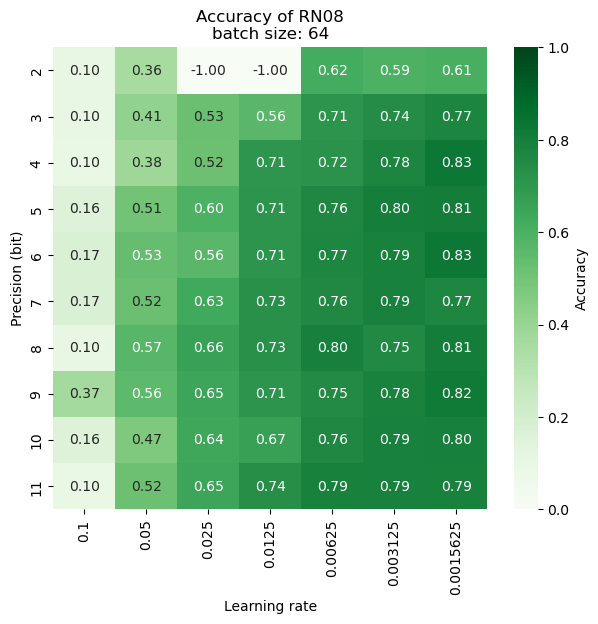

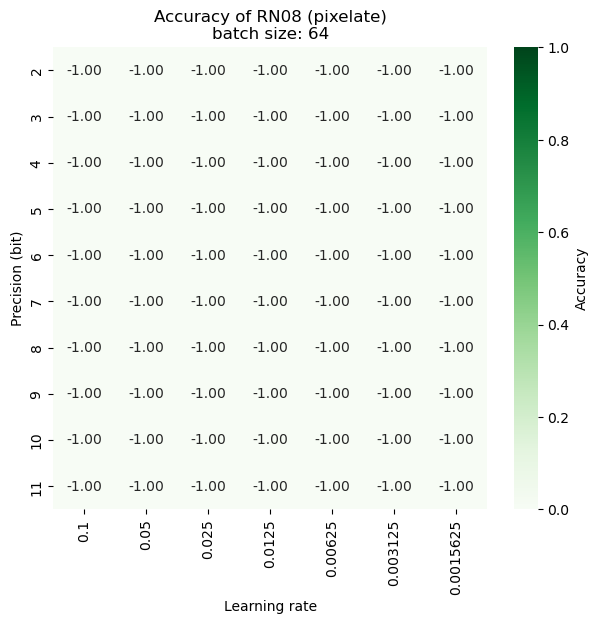

/data/tbaldi/work/checkpoint/bs128_lr0.1/RN08_2b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs128_lr0.1/RN08_3b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs128_lr0.1/RN08_4b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs128_lr0.1/RN08_5b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs128_lr0.1/RN08_6b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs128_lr0.1/RN08_7b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs128_lr0.1/RN08_8b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs128_lr0.1/RN08_9b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs128_lr0.1/RN08_10b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs128_lr0.1/RN08_11b/accuracy_pixelate.txt not found!
File not found! (/data/tbaldi/work/checkpoint/bs128_lr0.05/RN08_2b/accuracy_1.txt)
/data/tbaldi/work/checkpoint/bs128_lr0.05/RN08_2b/accuracy_pixelate.txt not found!
/data/tbaldi

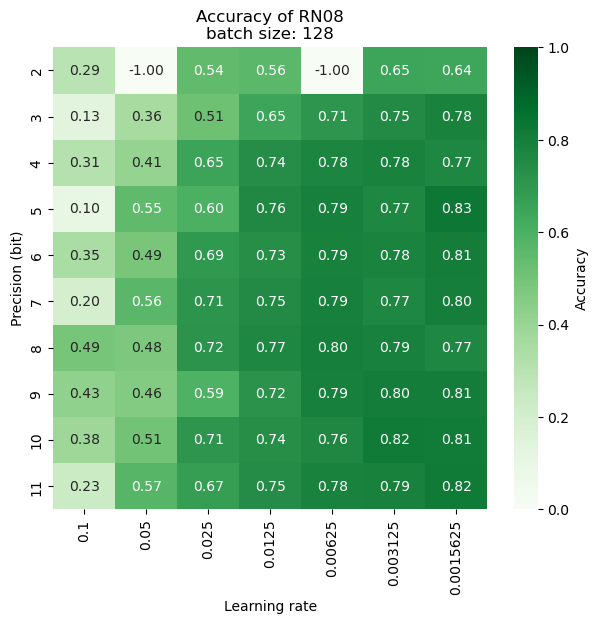

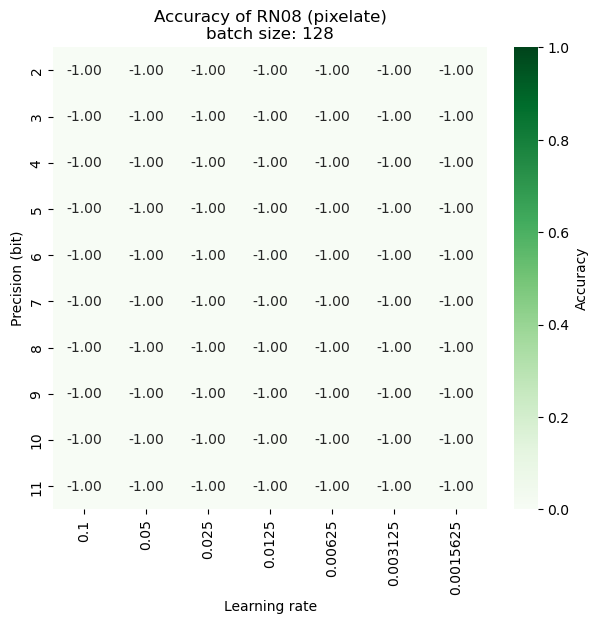

/data/tbaldi/work/checkpoint/bs256_lr0.1/RN08_2b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs256_lr0.1/RN08_3b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs256_lr0.1/RN08_4b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs256_lr0.1/RN08_5b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs256_lr0.1/RN08_6b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs256_lr0.1/RN08_7b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs256_lr0.1/RN08_8b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs256_lr0.1/RN08_9b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs256_lr0.1/RN08_10b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs256_lr0.1/RN08_11b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs256_lr0.05/RN08_2b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs256_lr0.05/RN08_3b/accuracy_pixelate.txt not found!
/data/tbaldi

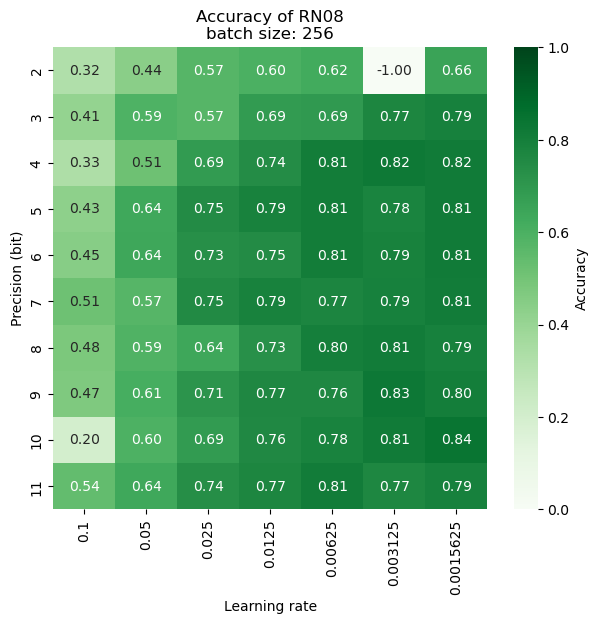

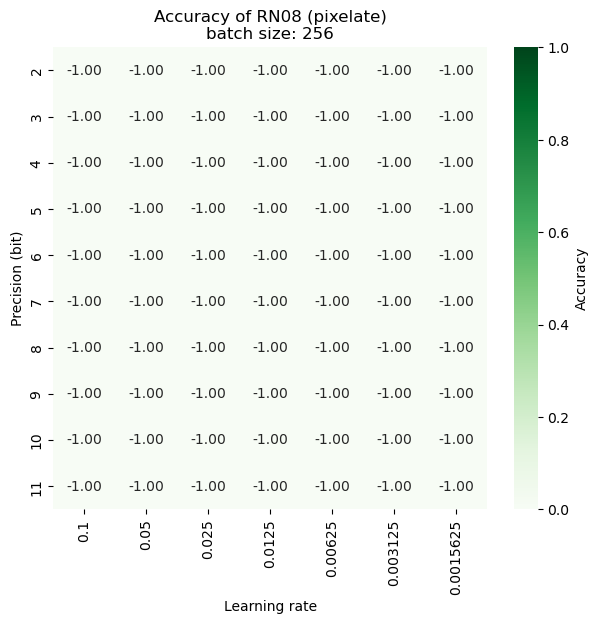

/data/tbaldi/work/checkpoint/bs512_lr0.1/RN08_2b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs512_lr0.1/RN08_3b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs512_lr0.1/RN08_4b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs512_lr0.1/RN08_5b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs512_lr0.1/RN08_6b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs512_lr0.1/RN08_7b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs512_lr0.1/RN08_8b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs512_lr0.1/RN08_9b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs512_lr0.1/RN08_10b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs512_lr0.1/RN08_11b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs512_lr0.05/RN08_2b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs512_lr0.05/RN08_3b/accuracy_pixelate.txt not found!
/data/tbaldi

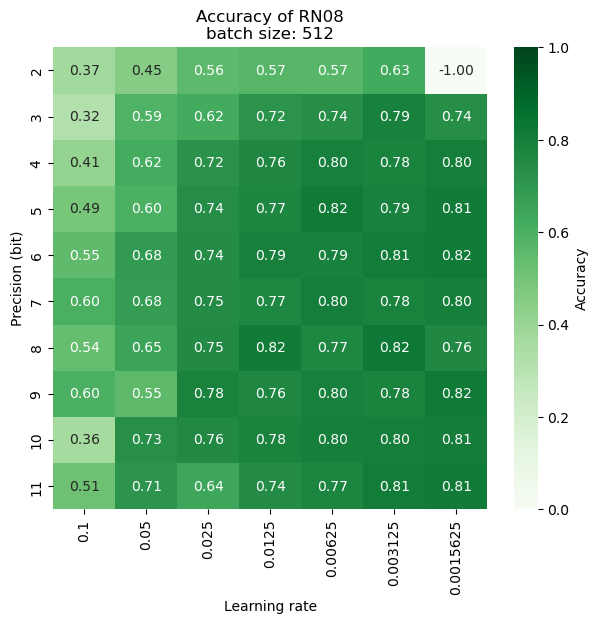

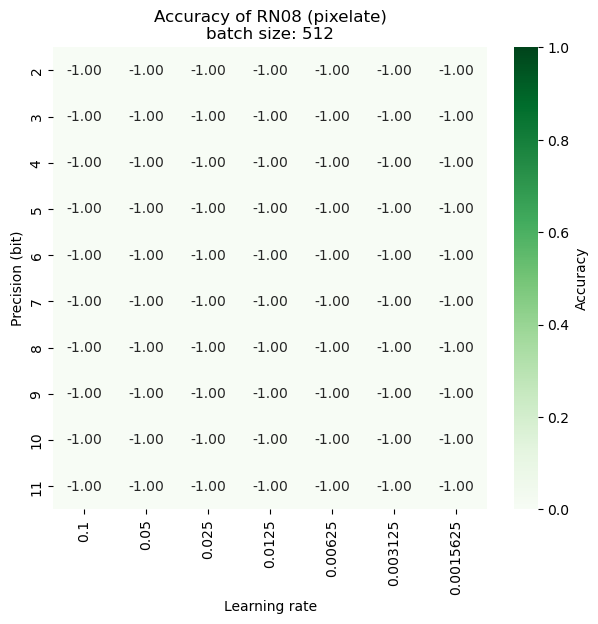

/data/tbaldi/work/checkpoint/bs1024_lr0.1/RN08_2b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs1024_lr0.1/RN08_3b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs1024_lr0.1/RN08_4b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs1024_lr0.1/RN08_5b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs1024_lr0.1/RN08_6b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs1024_lr0.1/RN08_7b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs1024_lr0.1/RN08_8b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs1024_lr0.1/RN08_9b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs1024_lr0.1/RN08_10b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs1024_lr0.1/RN08_11b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs1024_lr0.05/RN08_2b/accuracy_pixelate.txt not found!
/data/tbaldi/work/checkpoint/bs1024_lr0.05/RN08_3b/accuracy_pixelate.txt not found!


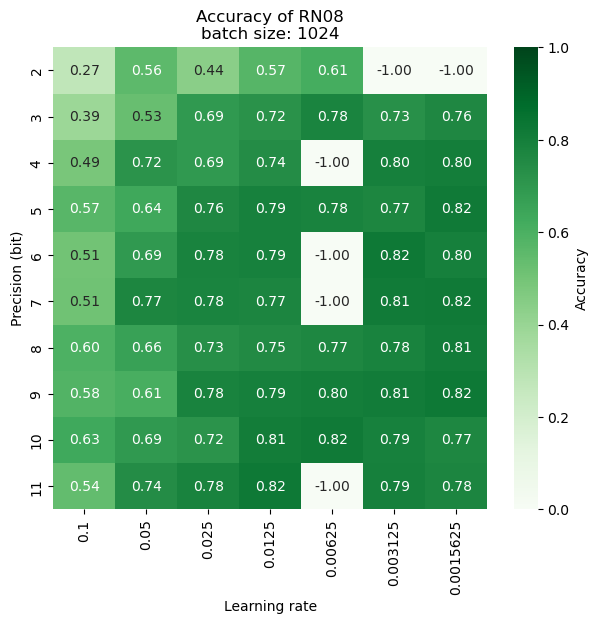

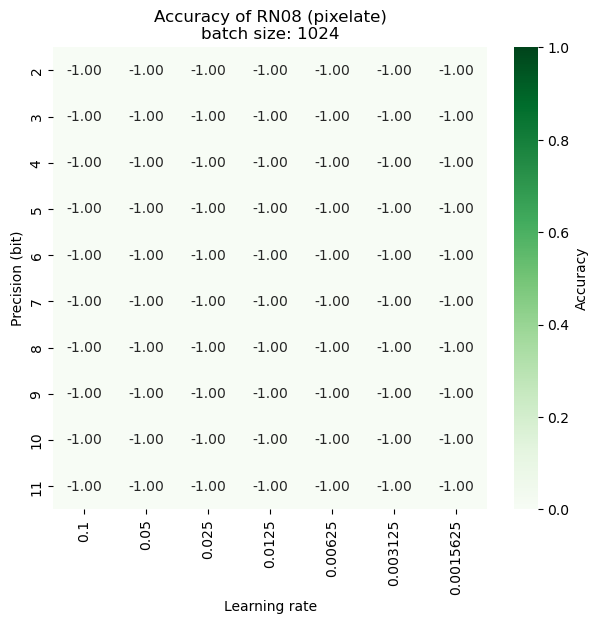

In [28]:

for bs in batch_sizes:
    matrix = np.zeros((len(precisions), len(learning_rates)))
    noise_matrix = np.zeros((len(precisions), len(learning_rates)))
    for y, lr in enumerate(learning_rates):
        for x, p in enumerate(precisions):
            
            # get the performances with and without noise
            acc = rn08.get_accuracy(DATA_PATH, bs, lr, p)
            noise_acc = rn08.get_accuracy_with_noise(DATA_PATH, bs, lr, p, noise_type)
            
            # build the heatmap matrix
            matrix[x, y] = acc
            noise_matrix[x, y] = noise_acc

            
    # plot the heatmaps per precision
    matrix = pd.DataFrame(matrix, 
                          index=precisions, 
                          columns=learning_rates)
    noise_matrix = pd.DataFrame(noise_matrix, 
                          index=precisions, 
                          columns=learning_rates)
    print(80*'-')
    plot_2d_heatmap(matrix, 
                    f'Accuracy of RN08\nbatch size: {bs}', 
                    (0, 1),
                    'Learning rate',
                    'Precision (bit)',
                    'Accuracy',
                    cmap='Greens')
    
    plot_2d_heatmap(noise_matrix, 
                    f'Accuracy of RN08 ({noise_type})\nbatch size: {bs}', 
                    (0, 1),
                    'Learning rate',
                    'Precision (bit)',
                    'Accuracy',
                    cmap='Greens')

# Jet Tagger (MLP)
The full precision model achieve 76% of accuracy.

In [29]:
def get_data_module(batch_size, num_workers=12):
    '''
    Method used to get the data modules used during the tests
    '''
    data_module = JetDataModule(
        data_dir=DATASET_DIR,
        data_file=os.path.join(DATASET_DIR, DATASET_FILE),
        batch_size=batch_size,
        num_workers=num_workers)
    
    # checek if we have processed the data
    if not os.path.exists(os.path.join(DATASET_DIR, DATASET_FILE)):
        print('Processing the data...')
        data_module.process_data(save=True)

    data_module.setup(0)
    return data_module


def load_model(batch_size, learning_rate, precision):
    '''
    Method used to get the model and the relative accuracy
    '''
    accuracy, idx = get_model_index_and_relative_accuracy(batch_size, learning_rate, precision)
    model_path = DATA_PATH + f'bs{batch_size}_lr{learning_rate}/JTAG_{precision}b/net_{idx}_best.pkl'
    
    # load the model
    model = JetTagger(
        quantize=(precision < 32),
        precision=[
            precision,
            precision,
            precision+3
        ],
        learning_rate=learning_rate,
    )
    
    # to set the map location
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model(torch.randn((16, 16)))  # Update tensor shapes 
    model_param = torch.load(model_path, map_location=device)
    model.load_state_dict(model_param['state_dict'])
    
    return model, accuracy


def get_model_index_and_relative_accuracy(batch_size, learning_rate, precision, num_tests=5):
    '''
    Return the average EMDs achieved by the model and the index of best experiment
    '''
    performances = []
    max_acc = 0
    max_acc_index = 0
    for i in range (1, num_tests+1):
        file_path = DATA_PATH + f'bs{batch_size}_lr{learning_rate}/' \
                    f'JTAG_{precision}b/accuracy_{i}.txt'
        try:
            jtag_file = open(file_path)
            jtag_text = jtag_file.read()
            accuracy = ast.literal_eval(jtag_text)
            accuracy = accuracy[0]['test_acc']
            performances.append(accuracy)
            if accuracy >= max_acc:
                max_acc = accuracy
                max_acc_index = i
            jtag_file.close()
        except Exception as e:
            # warnings.warn("Warning: " + file_path + " not found!")
            continue
        
    if len(performances) == 0:
        # warnings.warn(f"Attention: There is no accuracy value for the model: " \
        #               f"bs{batch_size}_lr{learning_rate}/JTAG_{precision}b")
        return
    
    return mean(performances), max_acc_index

## Accuracy results

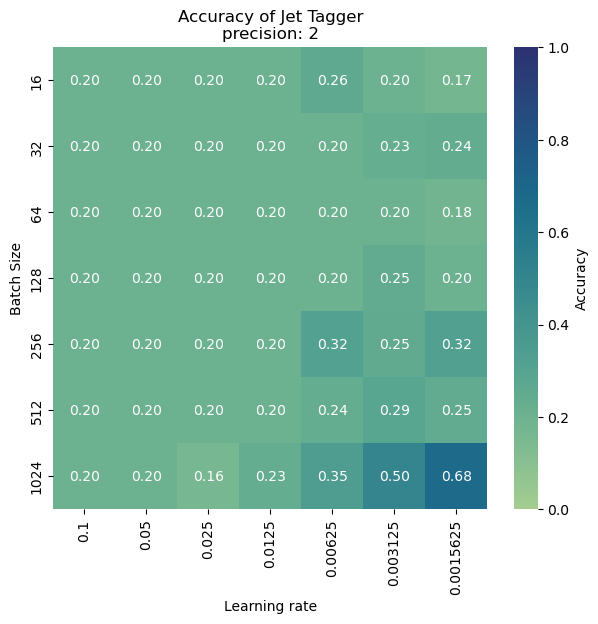

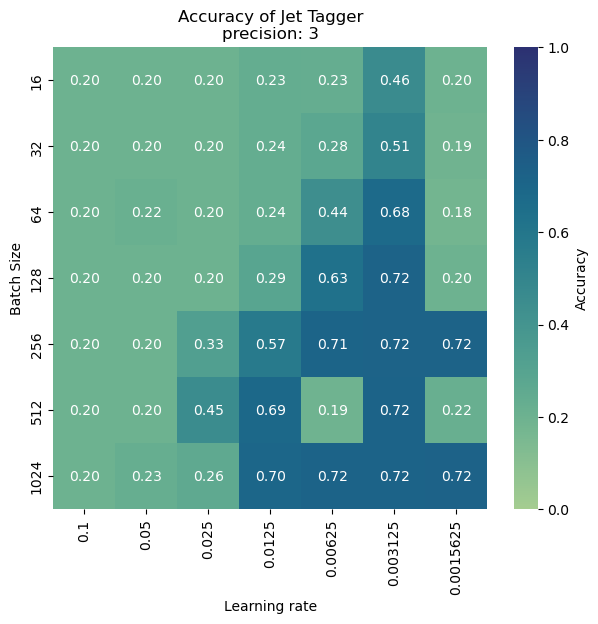

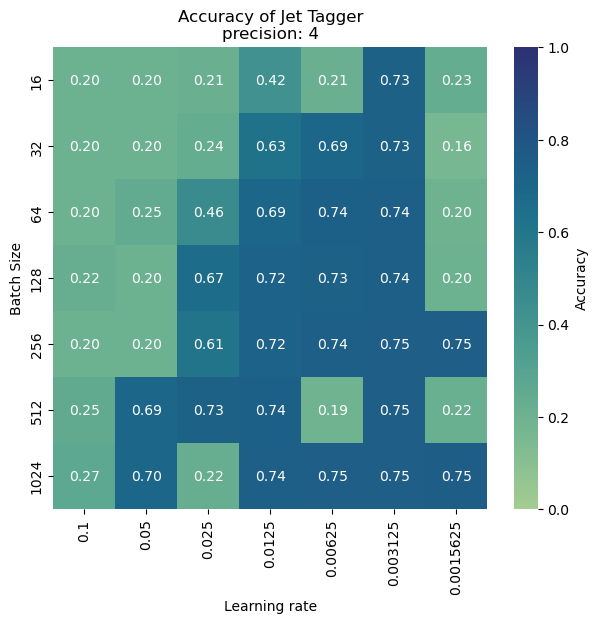

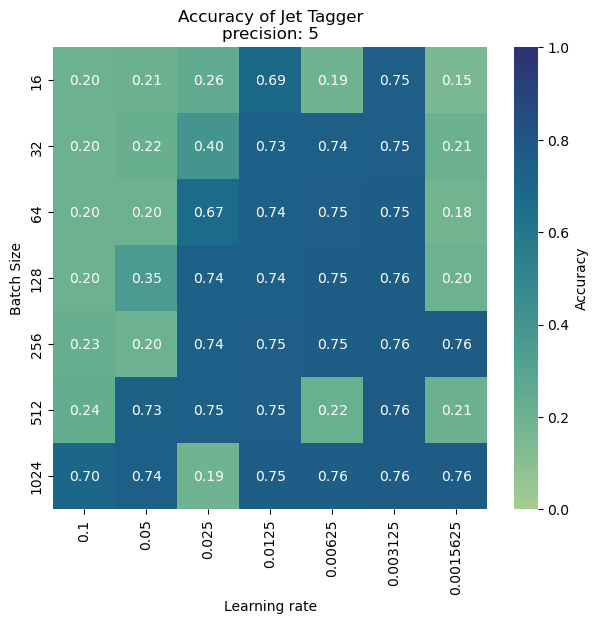

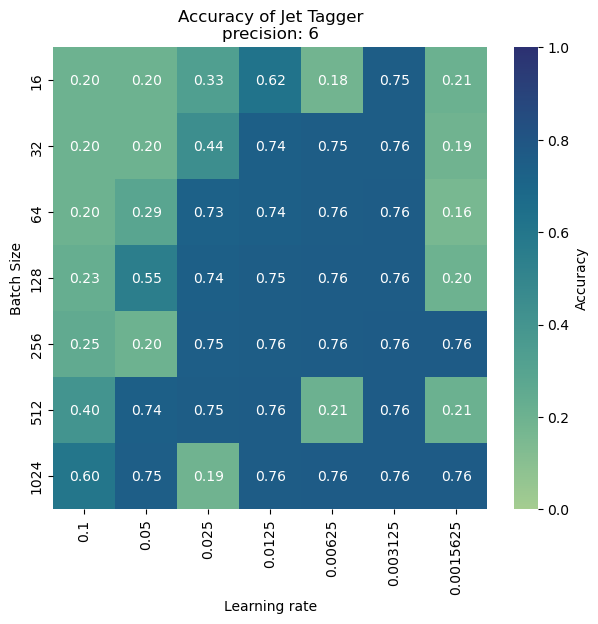

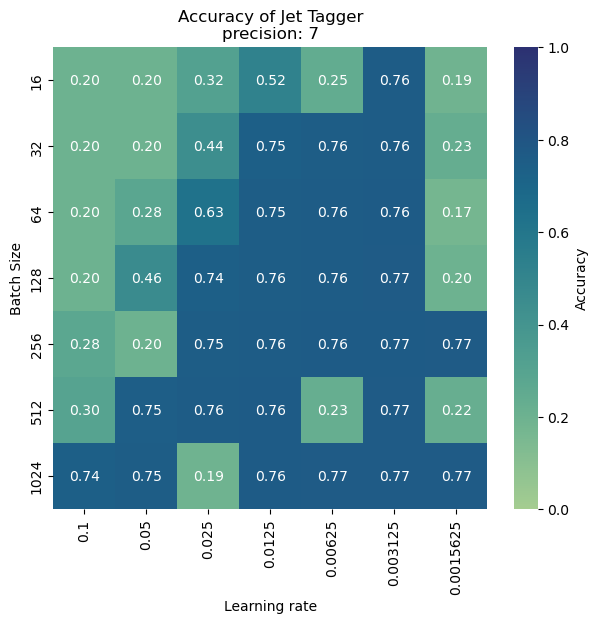

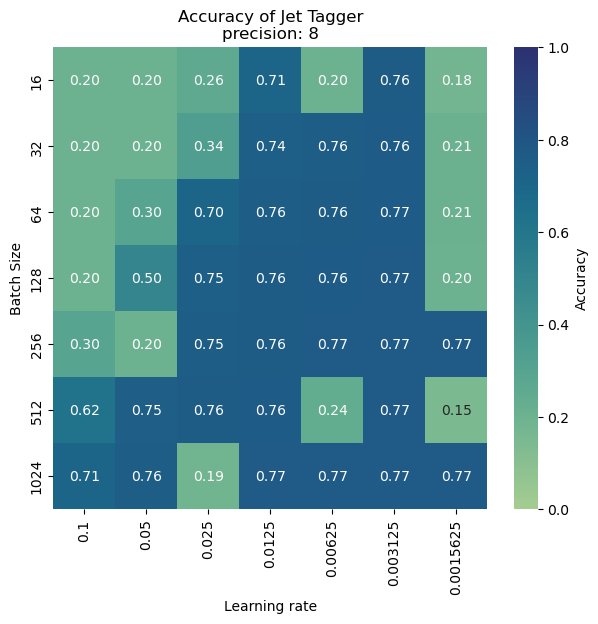

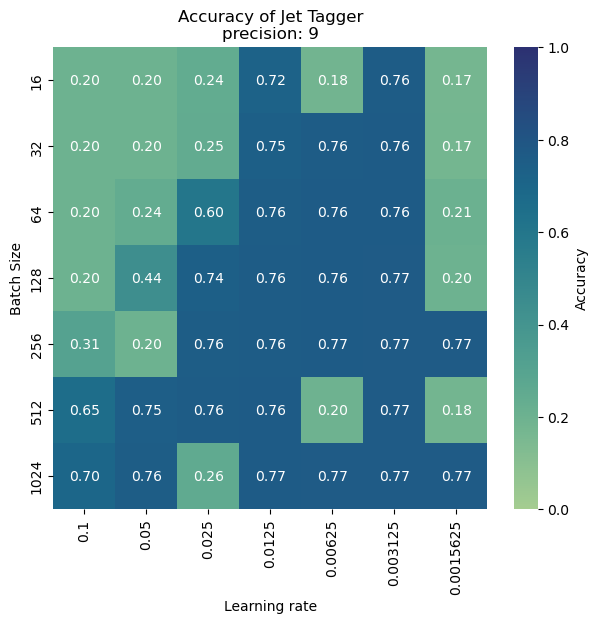

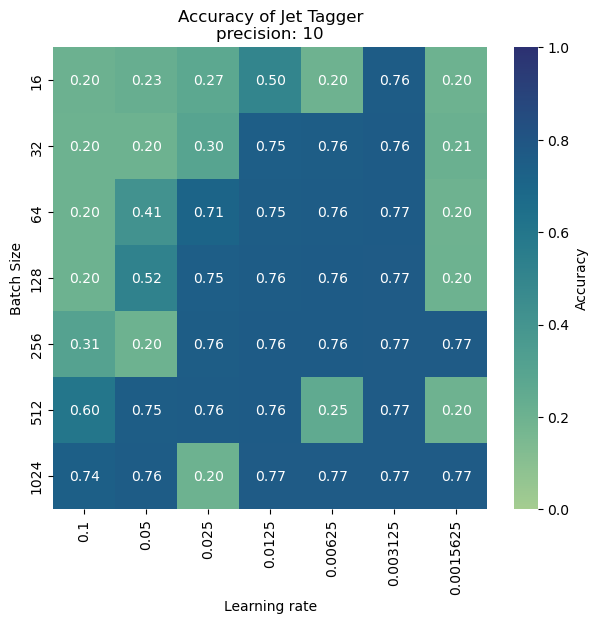

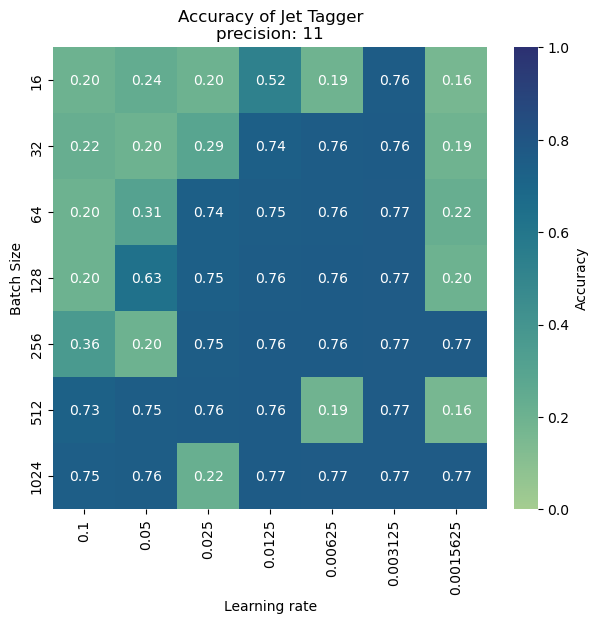

In [30]:
# plotting a heat map per layer
for p in precisions:
    accuracy_matrix = np.zeros((len(batch_sizes), len(learning_rates)))
    for x, bs in enumerate(batch_sizes):
        for y, lr in enumerate(learning_rates):
            mean_acc, _ = get_model_index_and_relative_accuracy(bs, lr, p)
            accuracy_matrix[x, y] = mean_acc
            
            
    accuracy_matrix = pd.DataFrame(accuracy_matrix, 
                                   index=batch_sizes, 
                                   columns=learning_rates)
    
    plot_2d_heatmap(accuracy_matrix, 
                    f'Accuracy of Jet Tagger\nprecision: {p}', 
                    (0, 1),
                    'Learning rate',
                    'Batch Size',
                    'Accuracy',
                    cmap='crest')

In [31]:
acc_distribution = []
for p in precisions:
    acc_matrix = np.zeros((len(batch_sizes), len(learning_rates)))
    for x, bs in enumerate(batch_sizes):
        for y, lr in enumerate(learning_rates):
            mean_acc, _ = get_model_index_and_relative_accuracy(bs, lr, p)
            acc_matrix[x, y] = mean_acc
            acc_distribution.append({
                'precision': p, 
                'accuracy': mean_acc,
                'batch_size': str(bs),
                'learning_rate': str(lr)
            })

In [32]:
acc_distribution_df = pd.DataFrame(acc_distribution)
acc_distribution_df = acc_distribution_df.sort_values(by='accuracy', ascending=False)
acc_distribution_df.head(10)

precision  accuracy batch_size learning_rate
489         11  0.768954       1024     0.0015625
426         10  0.768859        256     0.0015625
377          9  0.768732        256     0.0015625
342          8  0.768623       1024     0.0015625
390          9  0.768571       1024      0.003125
391          9  0.768535       1024     0.0015625
475         11  0.768075        256     0.0015625
341          8  0.767931       1024      0.003125
440         10  0.767913       1024     0.0015625
438         10  0.767898       1024       0.00625

let's focus on the top models:

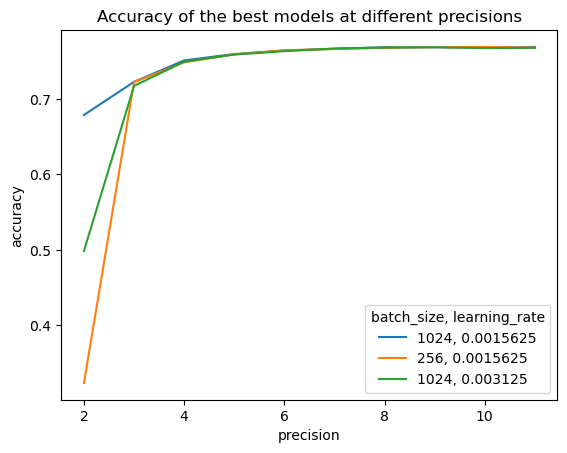

In [33]:
top_5_df = acc_distribution_df.loc[
    (acc_distribution_df.batch_size == '1024') & (acc_distribution_df.learning_rate == '0.0015625') |
    (acc_distribution_df.batch_size == '256') & (acc_distribution_df.learning_rate == '0.0015625') |
    (acc_distribution_df.batch_size == '256') & (acc_distribution_df.learning_rate == '0.0015625') |
    (acc_distribution_df.batch_size == '1024') & (acc_distribution_df.learning_rate == '0.0015625') |
    (acc_distribution_df.batch_size == '1024') & (acc_distribution_df.learning_rate == '0.003125')
    ]

hue = top_5_df[['batch_size', 'learning_rate']] \
        .apply(lambda row: f"{row.batch_size}, {row.learning_rate}", axis=1)
hue.name = 'batch_size, learning_rate'

sns.lineplot(top_5_df, x='precision', y='accuracy', hue=hue)
plt.title("Accuracy of the best models at different precisions")
plt.show()

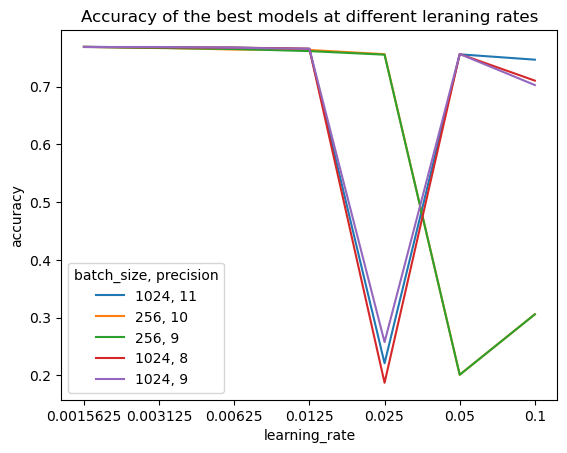

In [34]:
top_5_df = acc_distribution_df.loc[
    (acc_distribution_df.batch_size == '1024') & (acc_distribution_df.precision == 11) |
    (acc_distribution_df.batch_size == '256') & (acc_distribution_df.precision == 10) |
    (acc_distribution_df.batch_size == '256') & (acc_distribution_df.precision == 9) |
    (acc_distribution_df.batch_size == '1024') & (acc_distribution_df.precision == 8) |
    (acc_distribution_df.batch_size == '1024') & (acc_distribution_df.precision == 9)
    ]

top_5_df = top_5_df.sort_values(by='learning_rate', ascending=True)

hue = top_5_df[['batch_size', 'precision']] \
        .apply(lambda row: f"{row.batch_size}, {row.precision}", axis=1)
hue.name = 'batch_size, precision'

sns.lineplot(top_5_df, x='learning_rate', y='accuracy', hue=hue)
plt.title("Accuracy of the best models at different leraning rates")
plt.show()

## Scinetific Benchmark

In [35]:
def get_accuracy_with_noise(batch_size, learning_rate, precision, noise_type, percentage):
    '''
    Return the accuracy achieved by the Model with a certain level of noise
    '''

    file_path = DATA_PATH + f'bs{batch_size}_lr{learning_rate}/' \
                f'JTAG_{precision}b/accuracy_{noise_type}_{percentage}.txt'
    noise_acc = -1
    try:
        acc_file = open(file_path)
        acc_text = acc_file.read()
        acc = ast.literal_eval(acc_text)
        noise_acc = acc[0]['test_acc']
        acc_file.close()
    except Exception as e:
        # warnings.warn("Warning: " + file_path + " not found!")
        return 0
    return noise_acc

In [36]:
precisions = [4, 5, 6, 7, 8, 9, 10, 11]
noise_type = 'gaussian'

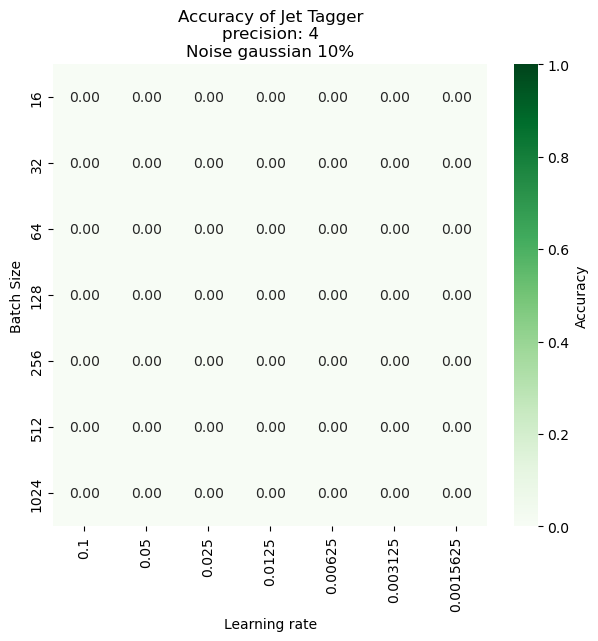

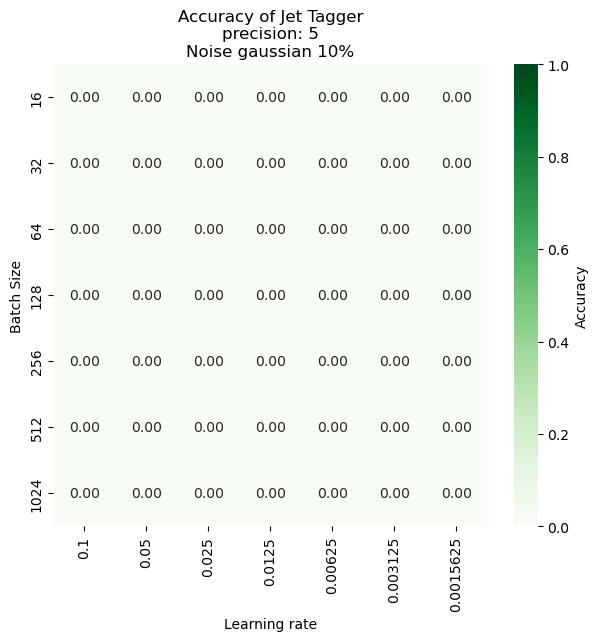

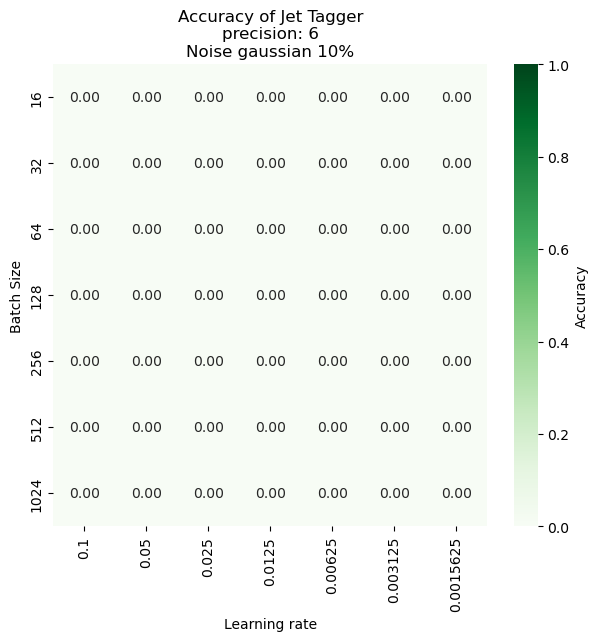

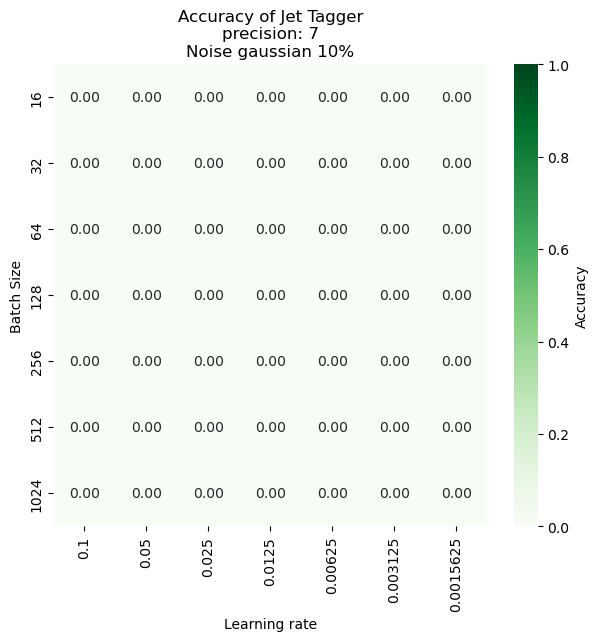

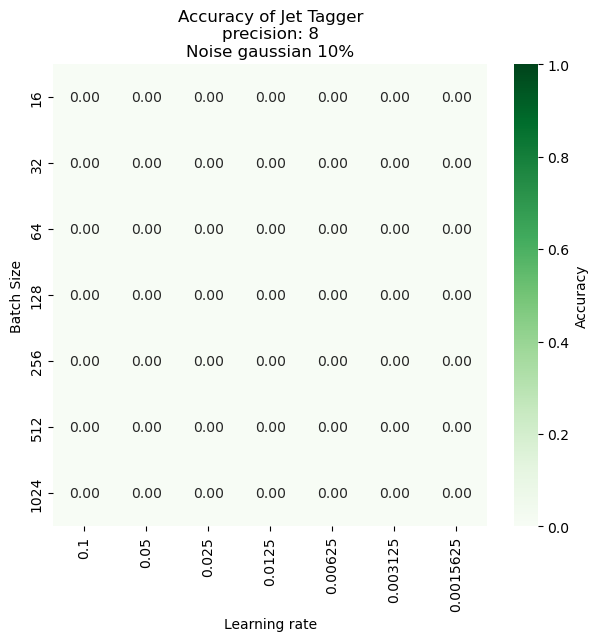

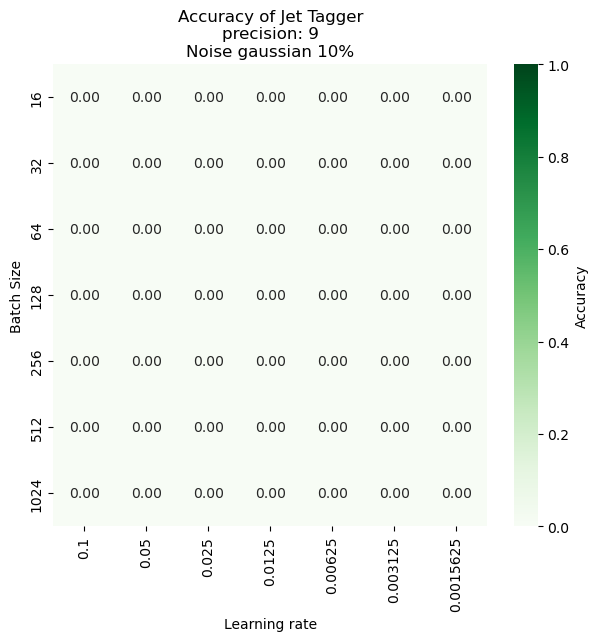

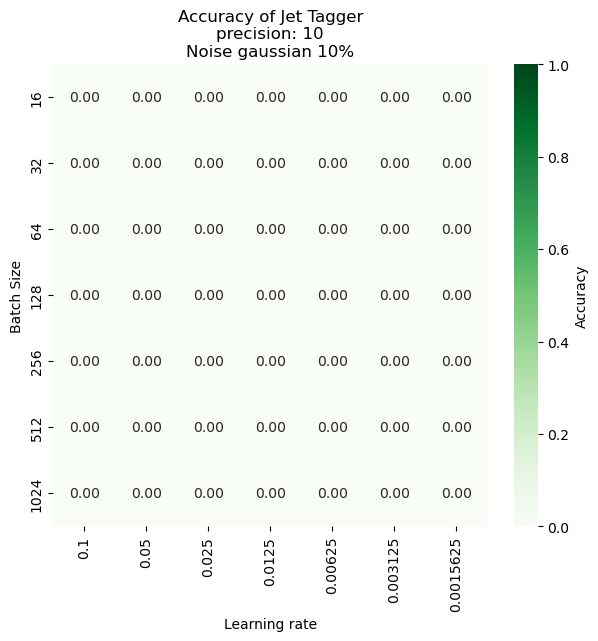

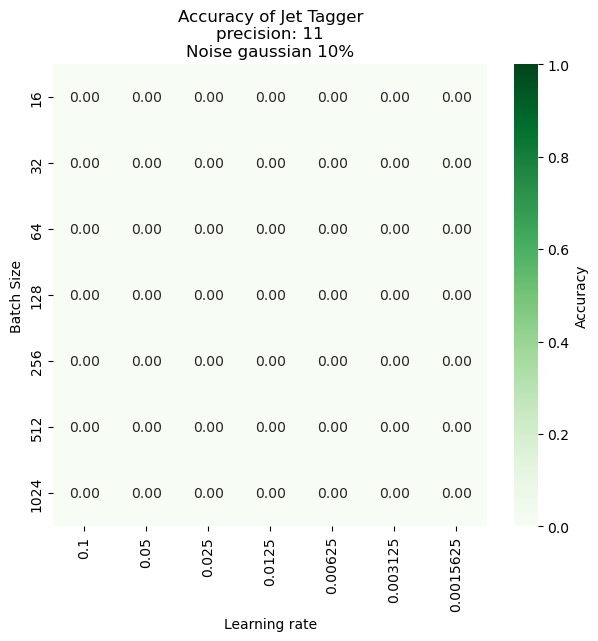

In [37]:
acc_distribution = []
for p in precisions:
    acc_matrix = np.zeros((len(batch_sizes), len(learning_rates)))
    for x, bs in enumerate(batch_sizes):
        for y, lr in enumerate(learning_rates):
            # get teh noise values
            noise_acc_20 = get_accuracy_with_noise(bs, lr, p, noise_type, 20)
            noise_acc_15 = get_accuracy_with_noise(bs, lr, p, noise_type, 15)
            noise_acc_10 = get_accuracy_with_noise(bs, lr, p, noise_type, 10)
            noise_acc_5 = get_accuracy_with_noise(bs, lr, p, noise_type, 5)
            original_acc, _ = get_model_index_and_relative_accuracy(bs, lr, p)
            
            # build the matrix for the heatmap
            acc_matrix[x, y] = noise_acc_20
            
            # store the values for the plots
            acc_distribution.append({
                'precision': p, 
                'accuracy': original_acc,
                'type': 'original',
                'batch_size': str(bs),
                'learning_rate': str(lr),
                'loss': 0
            })
            acc_distribution.append({
                'precision': p, 
                'accuracy': noise_acc_5,
                'type': '5%',
                'batch_size': str(bs),
                'learning_rate': str(lr),
                'loss': (original_acc - noise_acc_5) * 100 / original_acc,
                'original_acc': original_acc
            })
            acc_distribution.append({
                'precision': p, 
                'accuracy': noise_acc_10,
                'type': '10%',
                'batch_size': str(bs),
                'learning_rate': str(lr),
                'loss': (original_acc - noise_acc_10) * 100 / original_acc,
                'original_acc': original_acc
            })
            acc_distribution.append({
                'precision': p, 
                'accuracy': noise_acc_15,
                'type': '15%',
                'batch_size': str(bs),
                'learning_rate': str(lr),
                'loss': (original_acc - noise_acc_15) * 100 / original_acc,
                'original_acc': original_acc
            })
            acc_distribution.append({
                'precision': p, 
                'accuracy': noise_acc_20,
                'type': '20%',
                'batch_size': str(bs),
                'learning_rate': str(lr),
                'loss': (original_acc - noise_acc_20) * 100 / original_acc,
                'original_acc': original_acc
            })
            
    # heat map of the accuracy with noise as input per precision
    acc_matrix = pd.DataFrame(acc_matrix, 
                              index=batch_sizes, 
                              columns=learning_rates)
    
    plot_2d_heatmap(acc_matrix, 
                    f'Accuracy of Jet Tagger\nprecision: {p}\n' \
                    f'Noise {noise_type} 10%', 
                    (0, 1),
                    'Learning rate',
                    'Batch Size',
                    'Accuracy')
        

In [38]:
acc_distribution_df = pd.DataFrame(acc_distribution)
acc_distribution_df = acc_distribution_df.loc[acc_distribution_df.loss > -0.5]

In [39]:
noise = 5 # 5 10 15 20
top_noise_df = acc_distribution_df.loc[acc_distribution_df.type == f'{noise}%']
top_noise_df = top_noise_df.sort_values(by='original_acc', ascending=False)
top_noise_df.head(10)

precision  accuracy type batch_size learning_rate   loss  original_acc
1956         11       0.0   5%       1024     0.0015625  100.0      0.768954
1641         10       0.0   5%        256     0.0015625  100.0      0.768859
1396          9       0.0   5%        256     0.0015625  100.0      0.768732
1221          8       0.0   5%       1024     0.0015625  100.0      0.768623
1461          9       0.0   5%       1024      0.003125  100.0      0.768571
1466          9       0.0   5%       1024     0.0015625  100.0      0.768535
1886         11       0.0   5%        256     0.0015625  100.0      0.768075
1216          8       0.0   5%       1024      0.003125  100.0      0.767931
1711         10       0.0   5%       1024     0.0015625  100.0      0.767913
1701         10       0.0   5%       1024       0.00625  100.0      0.767898

Let's see how the previous top 5 models perform with noise:

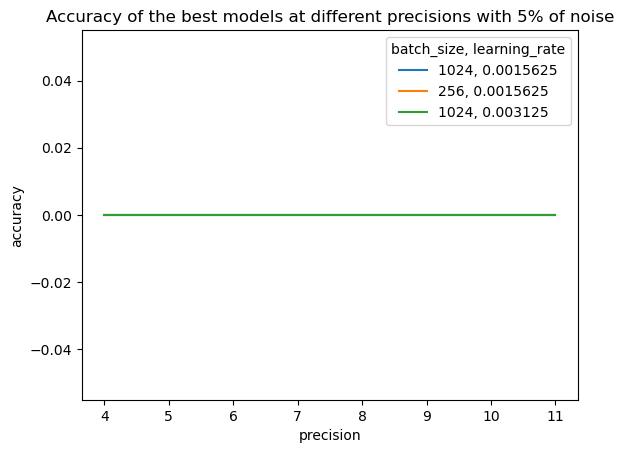

In [40]:
top_noise_df = top_noise_df.loc[
        (top_noise_df.batch_size == '1024') & (top_noise_df.learning_rate == '0.0015625') |
        (top_noise_df.batch_size == '256') & (top_noise_df.learning_rate == '0.0015625') |
        (top_noise_df.batch_size == '256') & (top_noise_df.learning_rate == '0.0015625') |
        (top_noise_df.batch_size == '1024') & (top_noise_df.learning_rate == '0.0015625') |
        (top_noise_df.batch_size == '1024') & (top_noise_df.learning_rate == '0.003125')
    ]
hue = top_noise_df[['batch_size', 'learning_rate']] \
        .apply(lambda row: f"{row.batch_size}, {row.learning_rate}", axis=1)
hue.name = 'batch_size, learning_rate'

sns.lineplot(top_noise_df, x='precision', y='accuracy', hue=hue)
plt.title("Accuracy of the best models at different precisions with 5% of noise")
plt.show()

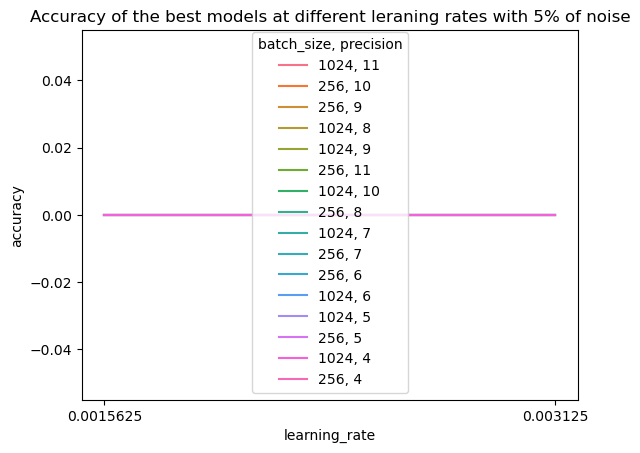

In [41]:
top_5_noise_df = top_noise_df.loc[
        (top_noise_df.batch_size == '1024') & (top_noise_df.precision == 11) |
        (top_noise_df.batch_size == '256') & (top_noise_df.precision == 10) |
        (top_noise_df.batch_size == '256') & (top_noise_df.precision == 9) |
        (top_noise_df.batch_size == '1024') & (top_noise_df.precision == 8) |
        (top_noise_df.batch_size == '1024') & (top_noise_df.precision == 9)
    ]
#top_5_noise_df = top_5_noise_df.sort_values(by='learning_rate', ascending=True)

hue = top_noise_df[['batch_size', 'precision']] \
        .apply(lambda row: f"{row.batch_size}, {row.precision}", axis=1)
hue.name = 'batch_size, precision'

sns.lineplot(top_noise_df, x='learning_rate', y='accuracy', hue=hue)
plt.title("Accuracy of the best models at different leraning rates with 5% of noise")
plt.show()

Let's look at the distribution of the accuracies per noise:

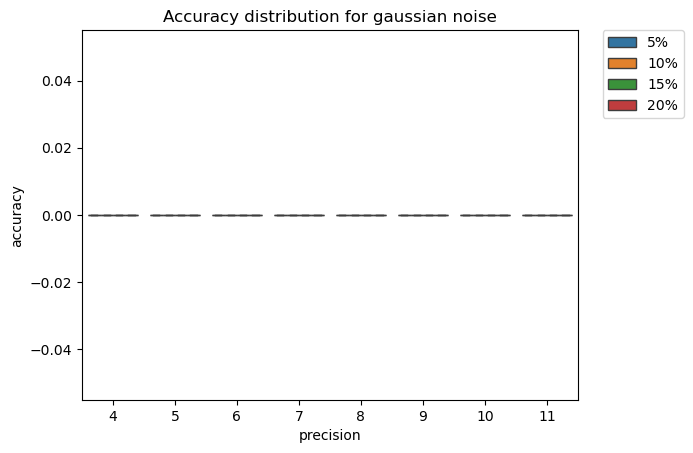

In [42]:
sns.boxplot(data=acc_distribution_df, 
            x='precision', 
            y='accuracy',
            hue='type',
            hue_order=['5%', '10%', '15%', '20%'],
            showfliers=False)

plt.title(f'Accuracy distribution for {noise_type} noise')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

Now we can focus only to those models that are more robust to noise.

IndexError: single positional indexer is out-of-bounds

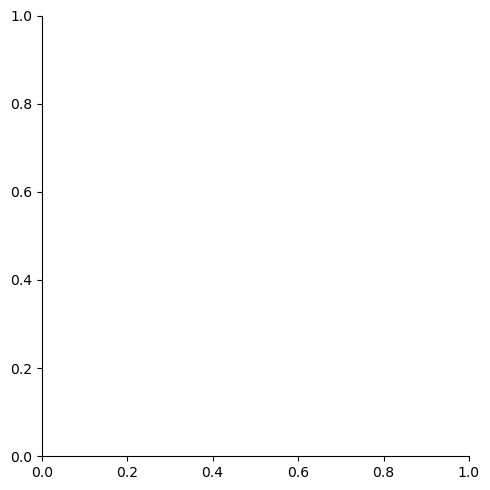

In [43]:
MAX_LOSS = 50
MIN_ACCURACY = 0.72
# filter the entries 
robust_df = acc_distribution_df.sort_values(by=['loss', 'original_acc'], ascending=[True, False])
robust_df = robust_df.drop(robust_df[robust_df.type == 'original'].index)
robust_df = robust_df.drop(robust_df[(robust_df.loss < -1) | (robust_df.loss > MAX_LOSS)].index)
robust_df = robust_df.drop(robust_df[robust_df.original_acc < MIN_ACCURACY].index)

sns.catplot(robust_df, y='loss', x='precision', hue='type', order=precisions)
plt.title(f'Robust models according to their loss\n' \
          f'minimum original accuracy: {MIN_ACCURACY}\n' \
          f'max loss: {MAX_LOSS}')
plt.show()

In [ ]:
noise_levels = [5, 10, 15, 20]
for noise in noise_levels:
    # Check the most robust models per noise
    df = robust_df.drop(robust_df[robust_df.type != f'{noise}%'].index)
    df = df.reset_index()
    
    sns.catplot(df, 
                x='precision', 
                y='loss', 
                hue='learning_rate', 
                order=precisions, 
                hue_order=[str(x) for x in learning_rates])
    plt.title(f'Robust models according to their loss with {noise}% of noise')
    sns.catplot(df, 
                x='precision', 
                y='loss', 
                hue='batch_size', 
                order=precisions, 
                hue_order=[str(x) for x in batch_sizes])
    plt.show()
    print(df[['original_acc', 'loss', 'batch_size', 'learning_rate', 'precision']].head(5))
    print(df[['original_acc', 'loss', 'batch_size', 'learning_rate', 'precision']].tail(5))
    df.to_csv(f"./out_JTAG_{noise}_{noise_type}.csv")

: 

plots of the best models in terms of loss.

In [ ]:
noise = 5 # 5 10 15 20
top_noise_df = robust_df.loc[robust_df.type == f'{noise}%']
top_noise_df = top_noise_df.sort_values(by='loss', ascending=True)
top_noise_df = top_noise_df.reset_index()
top_noise_df.head(5)

: 

In [ ]:
top_noise_df = top_noise_df.loc[
        (top_noise_df.batch_size == '16') & (top_noise_df.learning_rate == '0.0125') |
        (top_noise_df.batch_size == '64') & (top_noise_df.learning_rate == '0.025') |
        (top_noise_df.batch_size == '256') & (top_noise_df.learning_rate == '0.0125') |
        (top_noise_df.batch_size == '16') & (top_noise_df.learning_rate == '0.003125') |
        (top_noise_df.batch_size == '128') & (top_noise_df.learning_rate == '0.0125')
    ]
hue = top_noise_df[['batch_size', 'learning_rate']] \
        .apply(lambda row: f"{row.batch_size}, {row.learning_rate}", axis=1)
hue.name = 'batch_size, learning_rate'

sns.lineplot(top_noise_df, x='precision', y='accuracy', hue=hue)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title(f"Accuracy of the best models at different precisions with {noise}% of noise")
plt.show()

: 